In [1]:
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns
import torch.autograd as auto_grad
import matplotlib.pyplot as plt
from IPython import display
import time 

Model for solution equation y+y' = 3*exp(2x) <div>
True answer y(x) = exp(2x)

In [2]:
class PINN(nn.Module):  
    
    def __init__(self, n_inp: int=1, n_out: int=1, hidden: int=8):
        super().__init__()
        self.input_layer = nn.Linear(n_inp, hidden)
        self.gelu_1 = nn.GELU()
        self.hidden_layer_1 = nn.Linear(hidden, hidden)
        self.gelu_2 = nn.GELU()
        self.output_layer = nn.Linear(hidden, n_out)

    def forward(self, x):
        out = self.input_layer(x)
        out = self.gelu_1(out)
        out = self.hidden_layer_1(out)
        out = self.gelu_2(out)
        out = self.output_layer(out)
        return out


In [3]:
# Create dict initial condition
massiv_of_initials = {("x", 0): 1}

In [4]:
def f_equas(model , x):
    """Find loss from equation"""
    x = auto_grad.Variable(x, requires_grad=True)
    y = model(x)
    y_x = auto_grad.grad(y, x, create_graph=True)
    f_n = y_x[0] + y - 3 * torch.exp(2 * x)
    return (f_n) ** 2


In [5]:
def initial(model, x):
    """ Find loss from initial condition"""
    if ("x", x.item()) in massiv_of_initials:
        T = model(x)
        return (massiv_of_initials[("x", x.item())] - T) ** 2
    return torch.zeros(1)


In [43]:
def plot_seaborn(array_counter, array_score):
    sns.set(color_codes=True, font_scale=1.5)
    sns.set_style("white")
    plt.figure(figsize=(13, 8))
    fit_reg = True
    ax = sns.regplot(
        x=np.array([array_counter])[0],
        y=np.array([array_score])[0],
        x_jitter=0.1,
        scatter_kws={"color": "#36688D"},
        label="Data",
        fit_reg=fit_reg,
        line_kws={"color": "#F49F05"},
    )
    # Plot the average line
    y_mean = [np.mean(array_score)] * len(array_counter)
    ax.plot(array_counter, y_mean, label="Mean", linestyle="--")
    ax.legend(loc="upper right")
    ax.set(xlabel="# epoch", ylabel="loss")
    display.display(plt.gcf())
    time.sleep(0.5)
    plt.cla()
    display.clear_output(wait =True)


In [7]:
def create_mass(num_elem: int=1000, points=None)-> torch.Tensor:
    """ Generate or take points to create tensor, 
        in addition generate 10% points in initial condition from num_elem 
    """
    # Create massive with random variavles
    massive_inside = points if points else np.random.uniform(0, 1, (num_elem, 1))
    # addition create massive for initial condition
    massive_bound_x_0 = np.zeros((int(num_elem*0.1), 1))
    # Unite massives, shuffle data and transform to Tensor
    massive = np.concatenate(
        (
            massive_inside,
            massive_bound_x_0,
        )
    )
    np.random.shuffle(massive)
    return torch.Tensor(massive)

In [44]:
# Create data
train_data = create_mass(2000)
val_data = create_mass(300)

# Create model and its parameters
model_nn = PINN()
learning_rate = 8e-6
optimizer = torch.optim.Adam(model_nn.parameters(), lr=learning_rate)
epochs = 1000


KeyboardInterrupt: 

Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x000001CFA9A422A0>
Traceback (most recent call last):
  File "C:\Users\n.zhilenkova\AppData\Local\anaconda3\Lib\site-packages\matplotlib\transforms.py", line 198, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id_self: pop(k))
                                                       ^^^^^^
KeyboardInterrupt: 


Error in callback <function _draw_all_if_interactive at 0x000001CF7359F9C0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

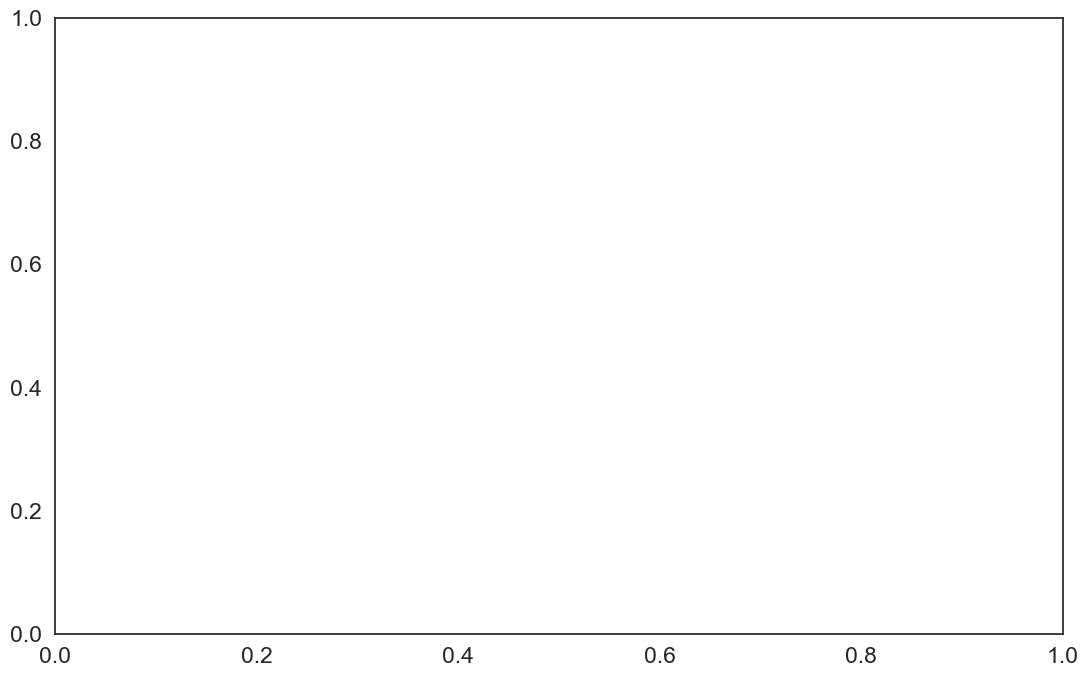

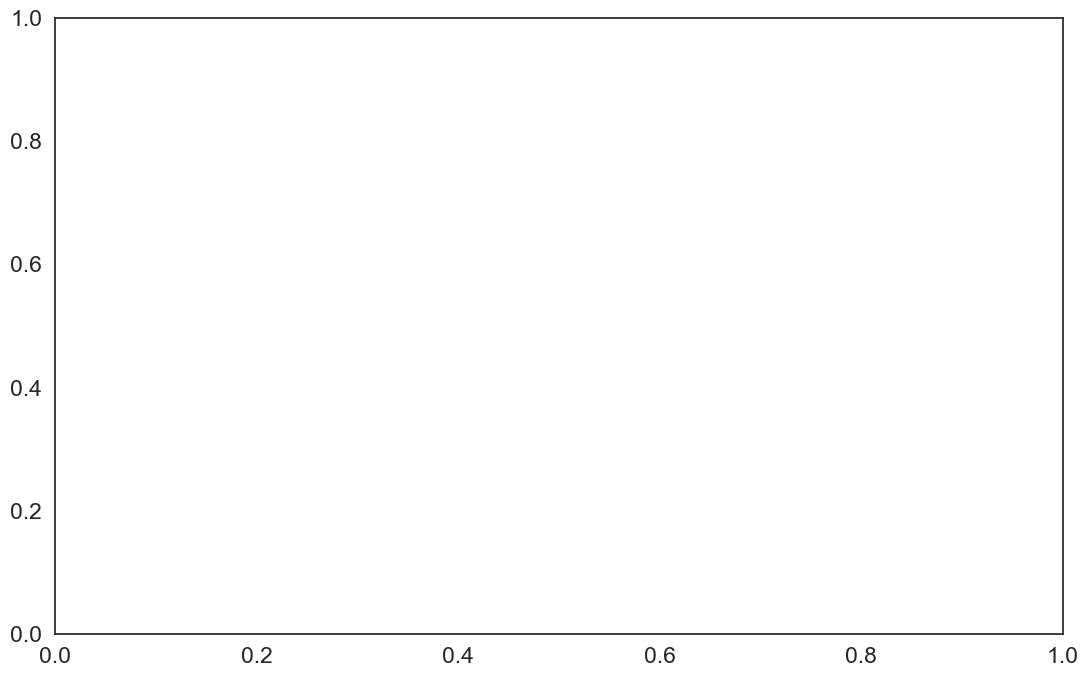

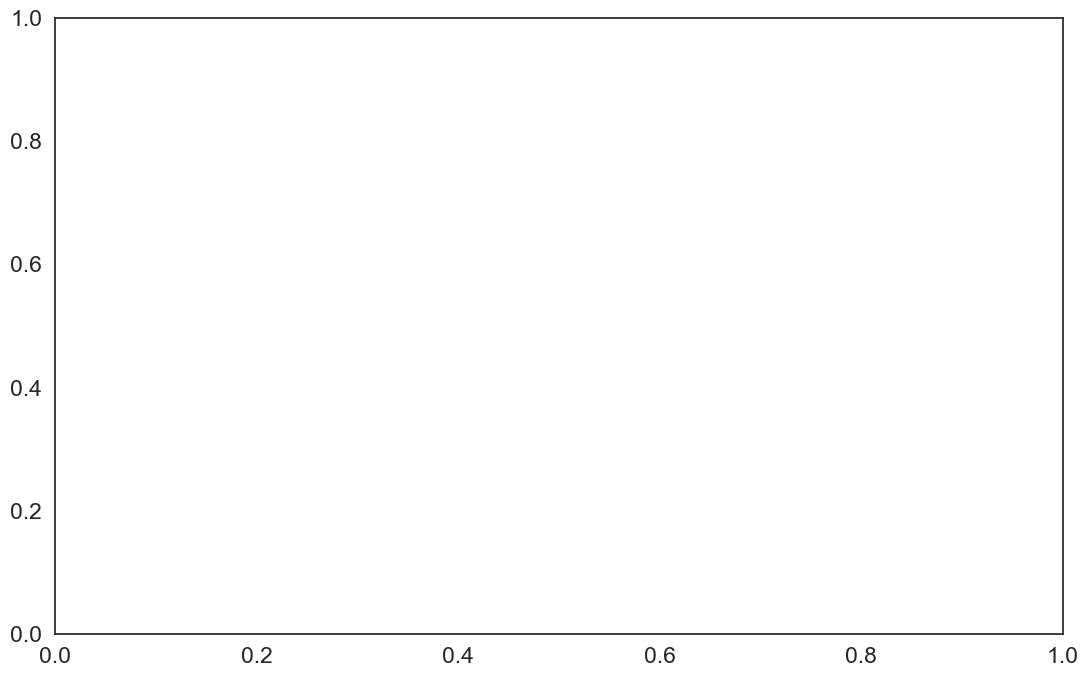

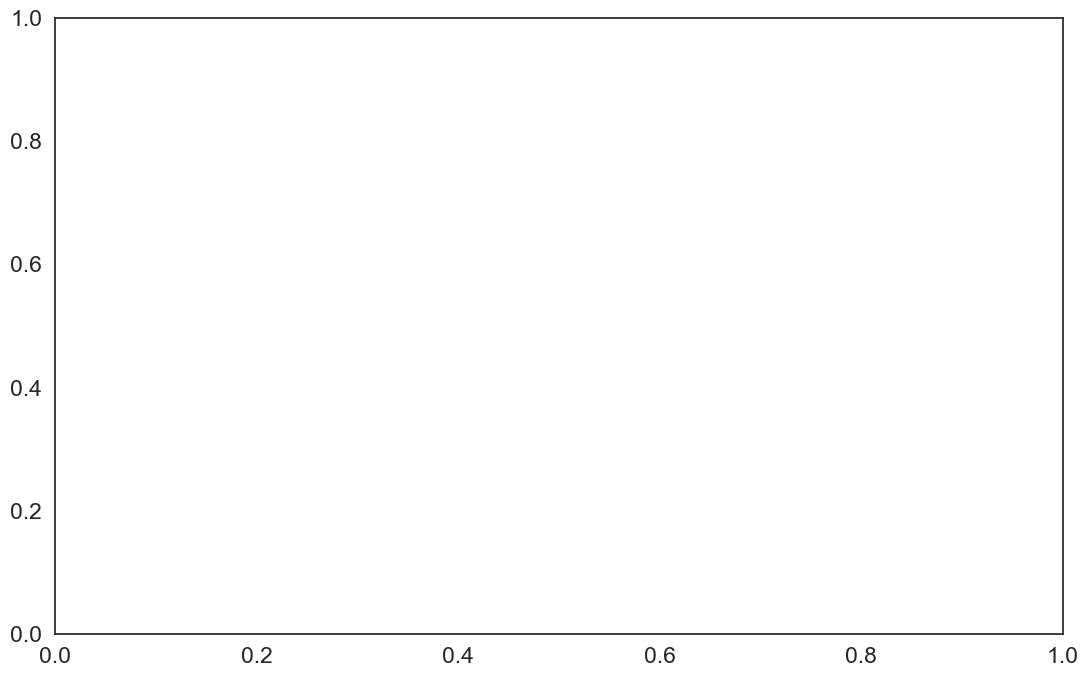

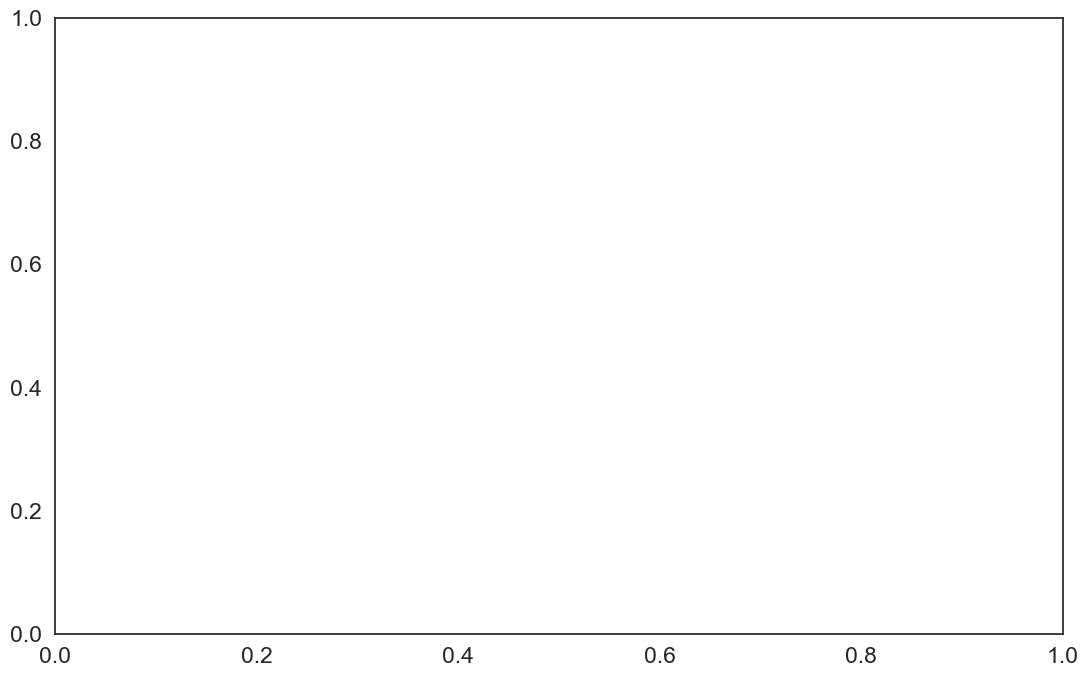

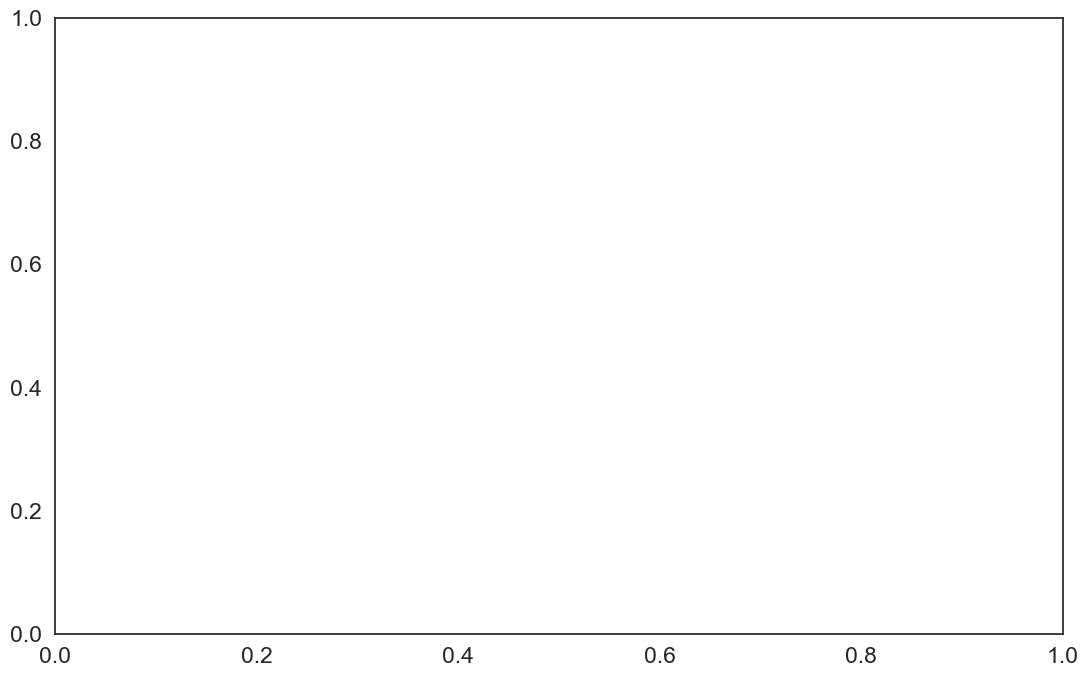

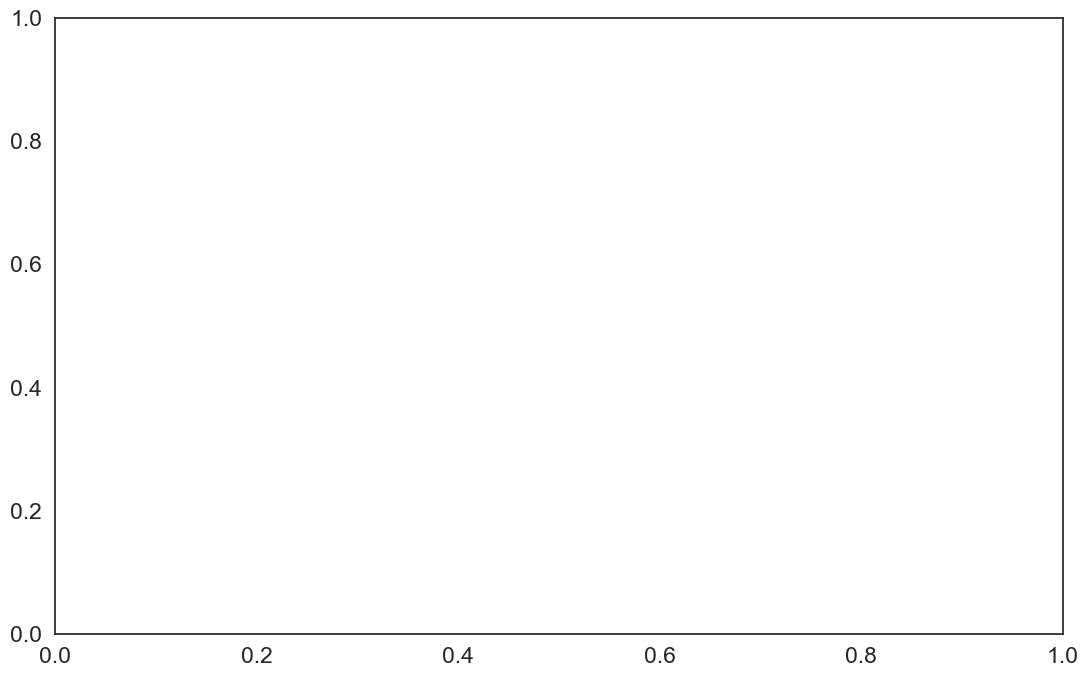

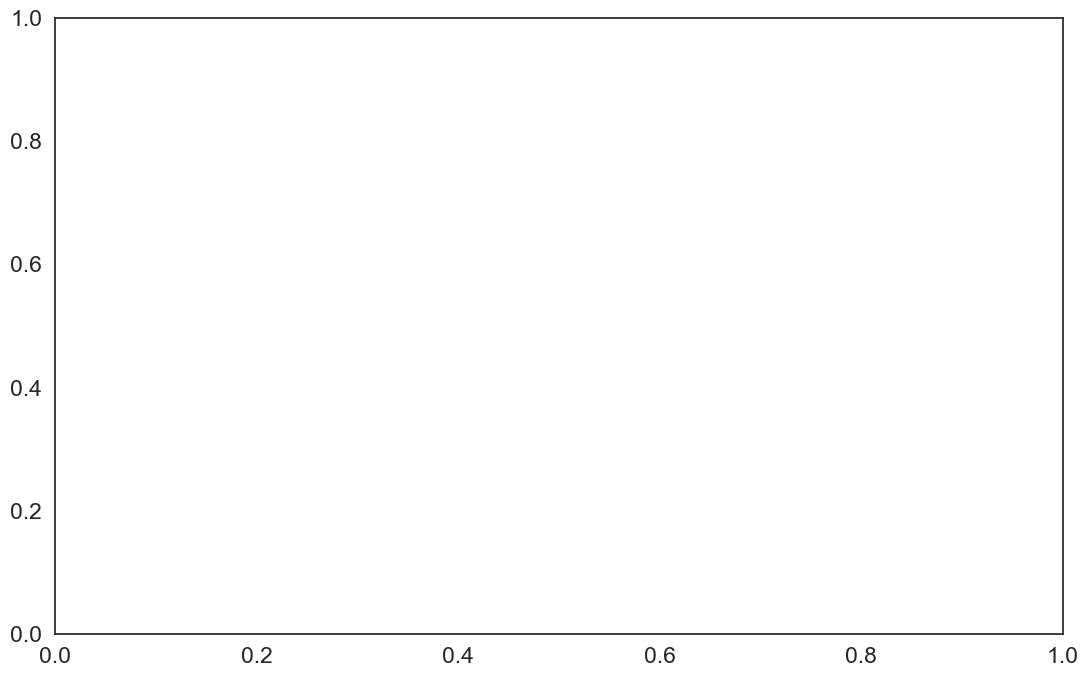

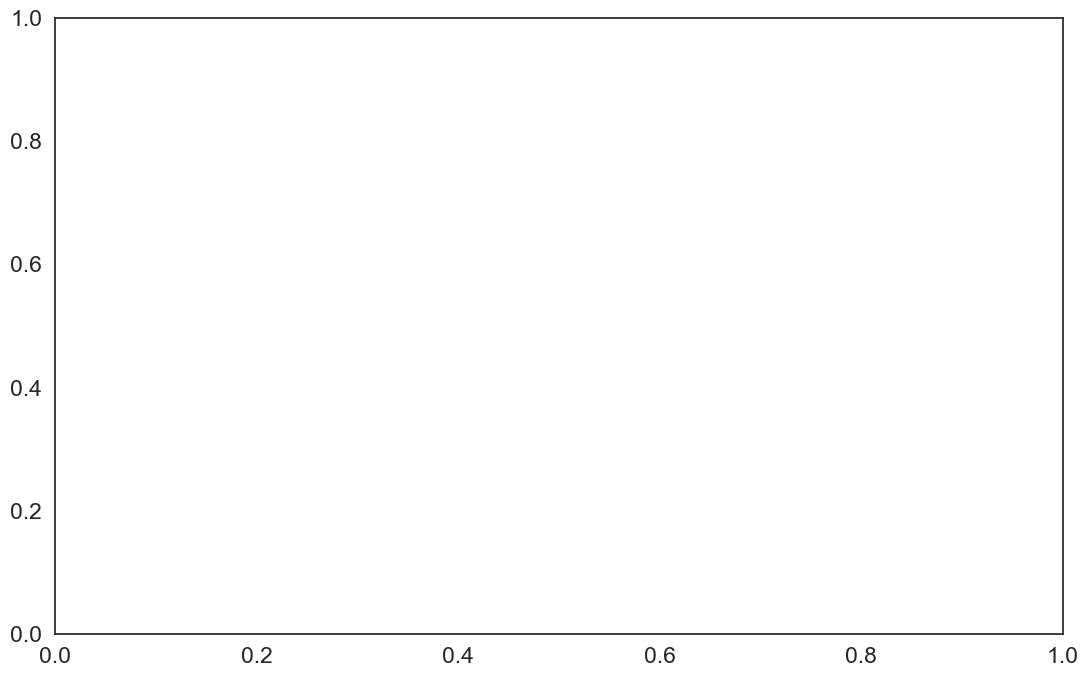

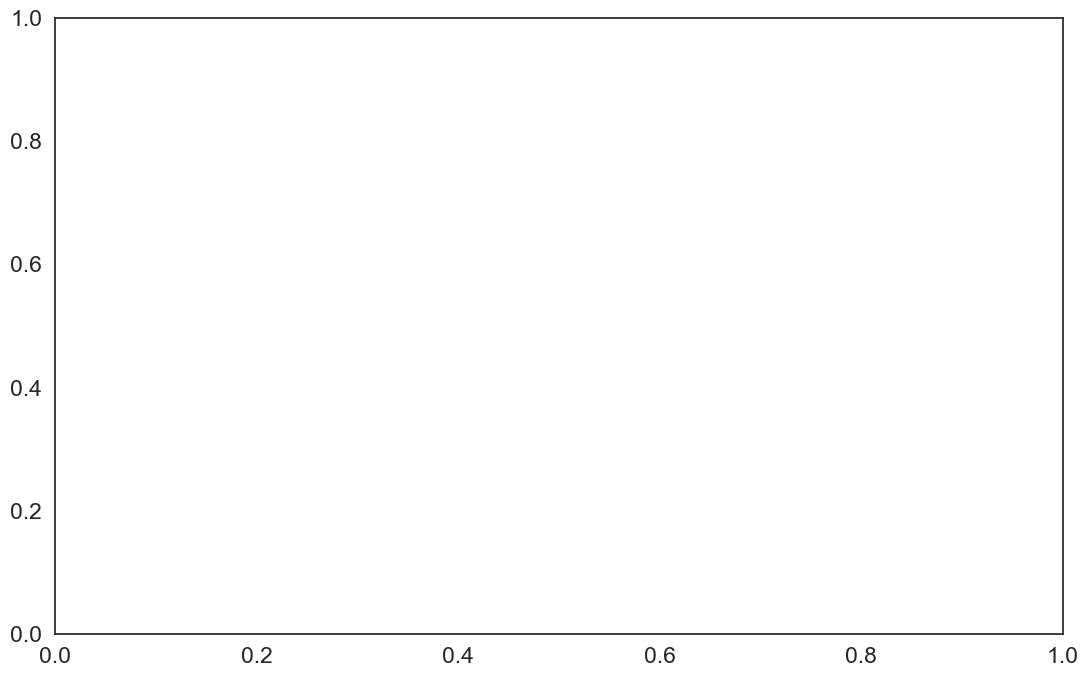

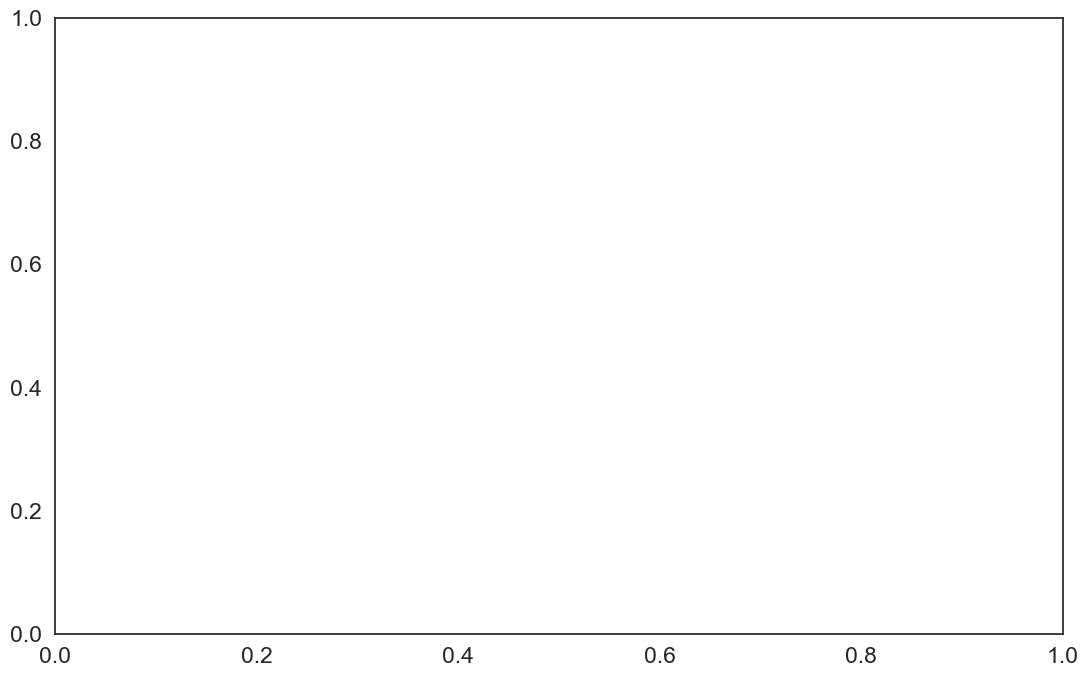

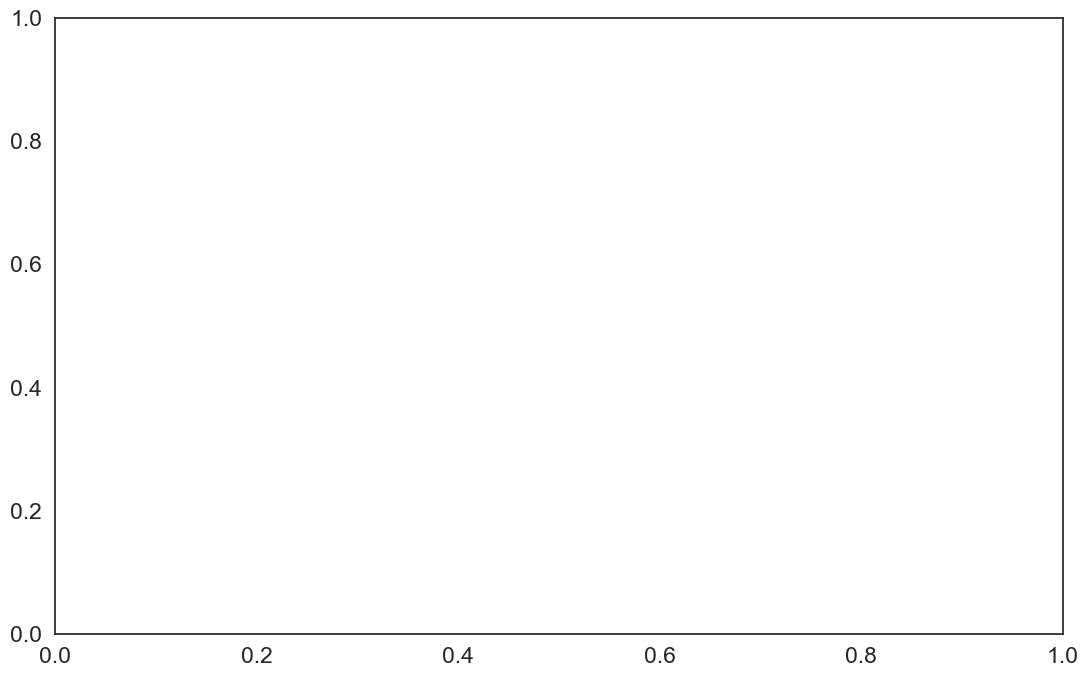

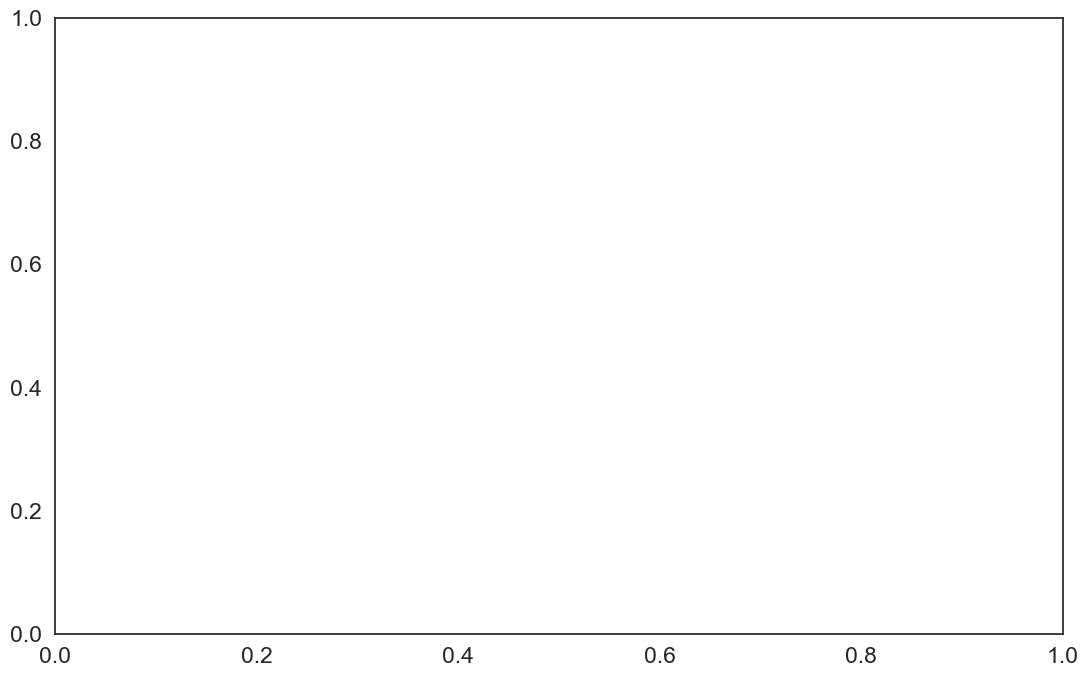

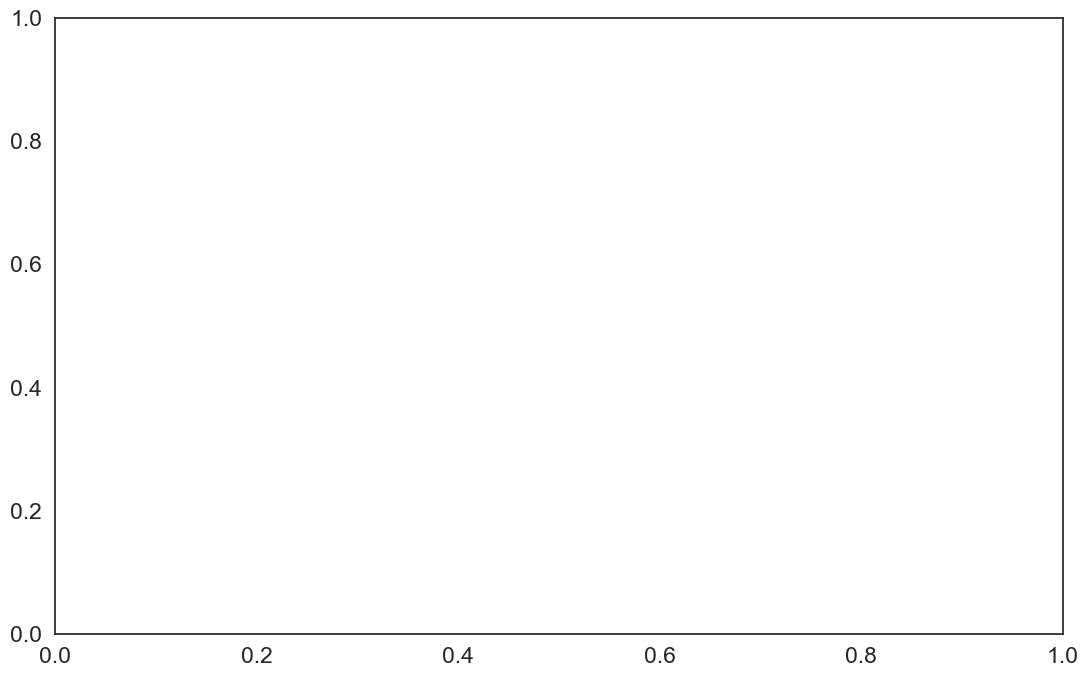

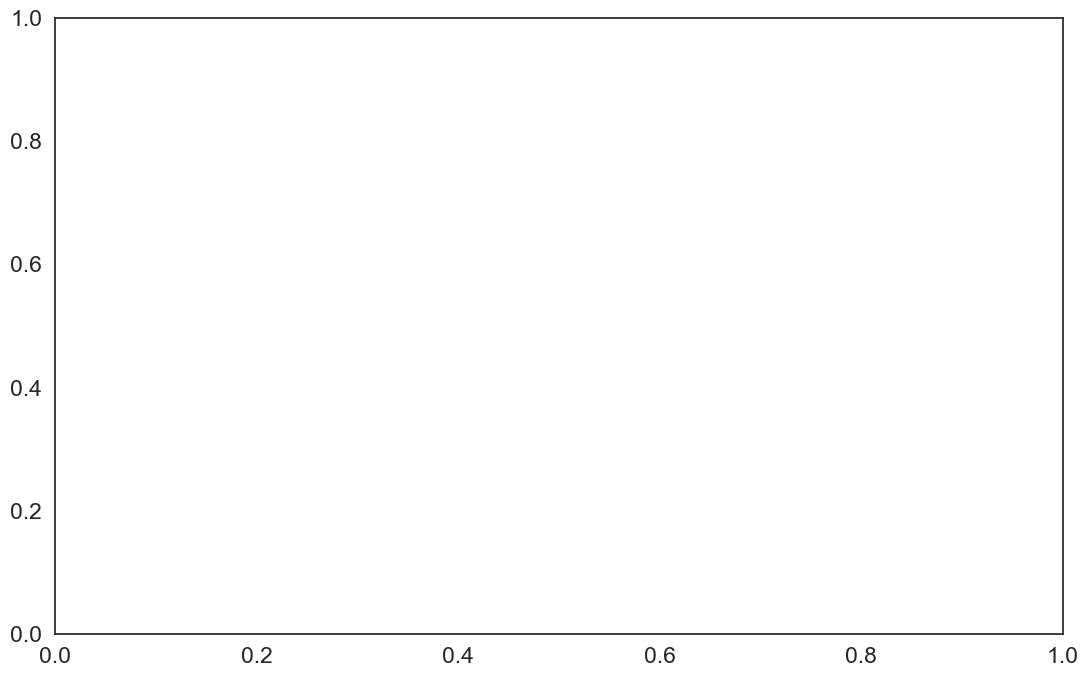

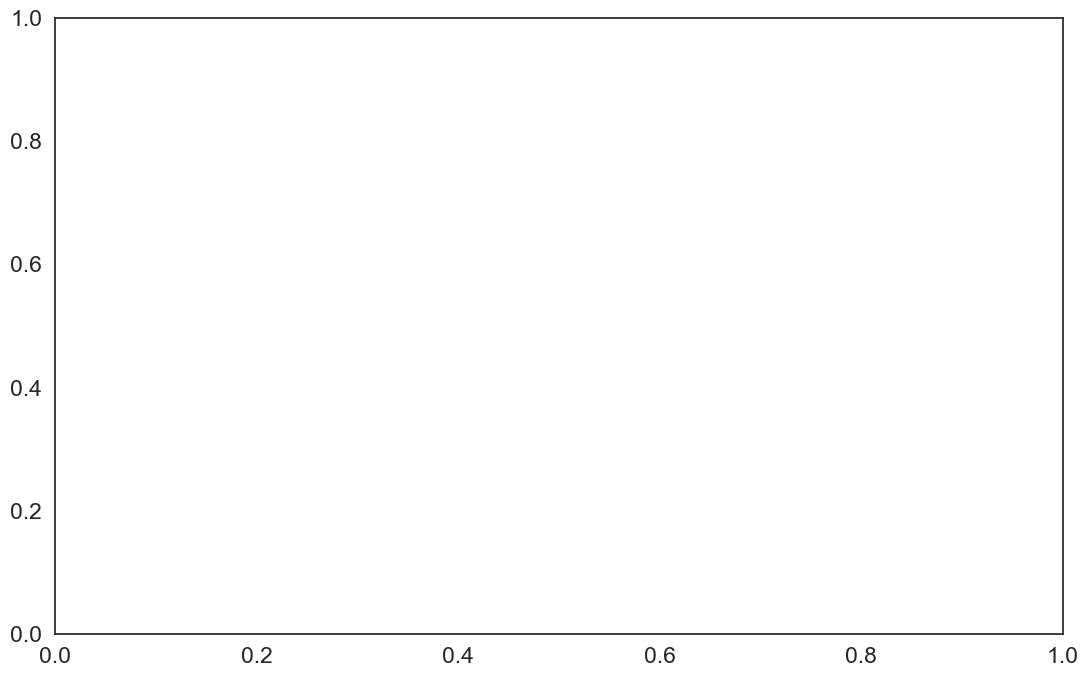

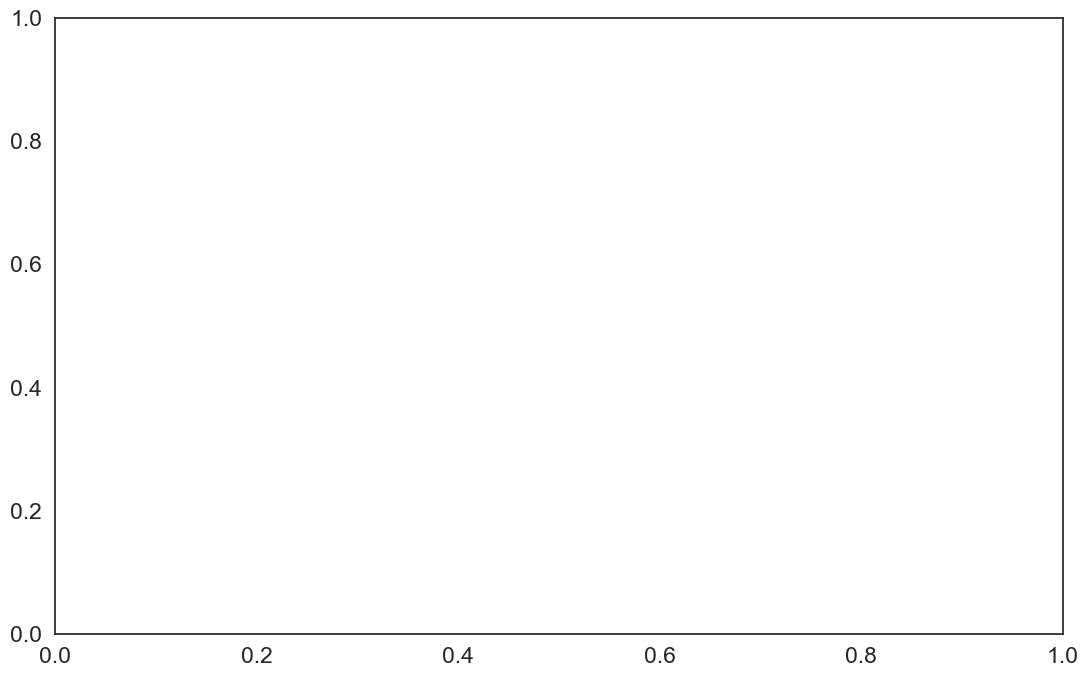

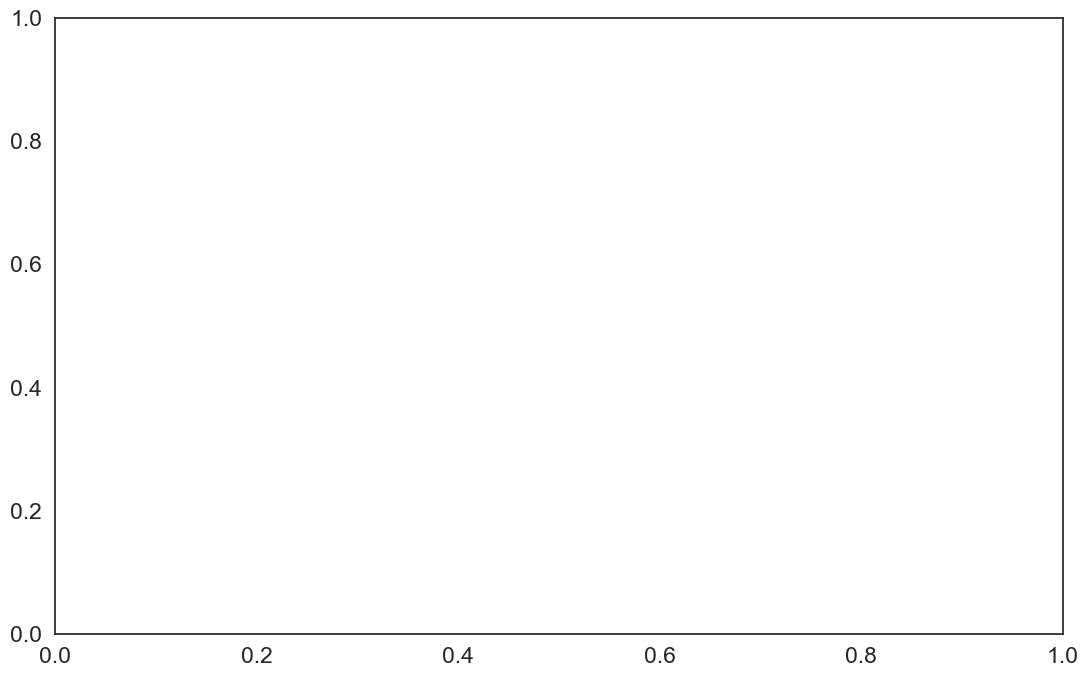

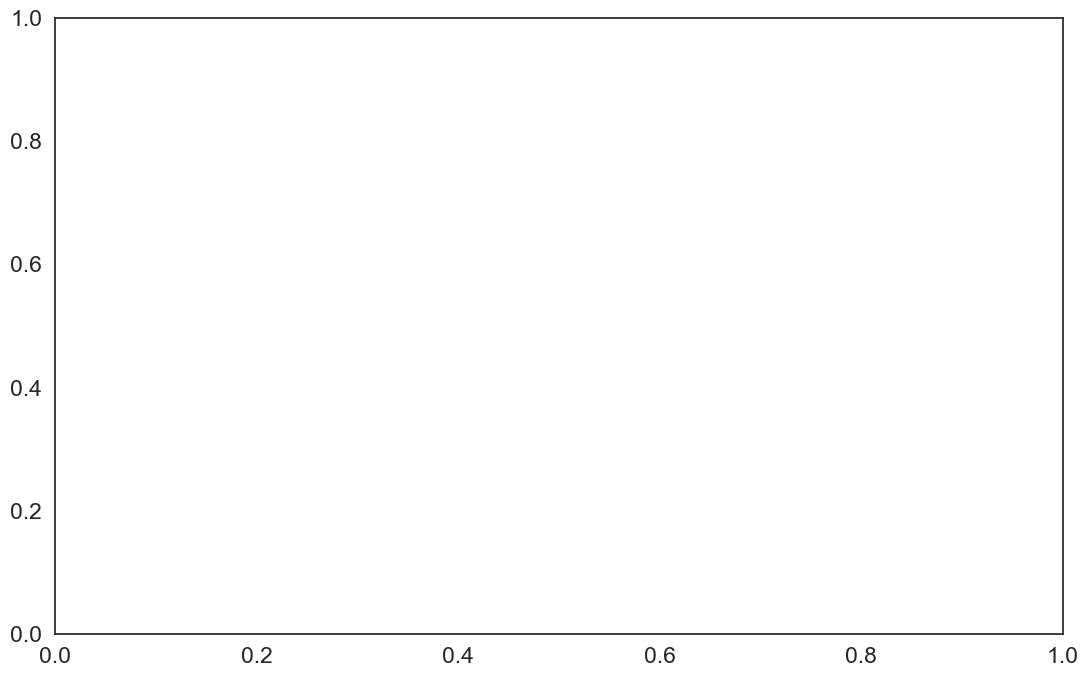

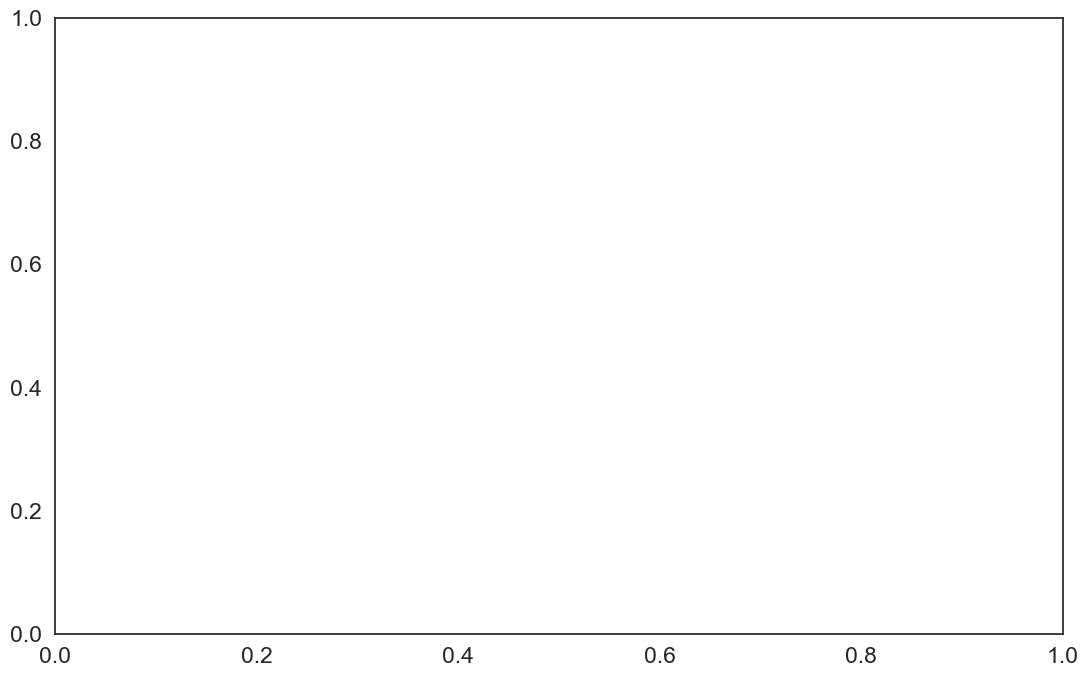

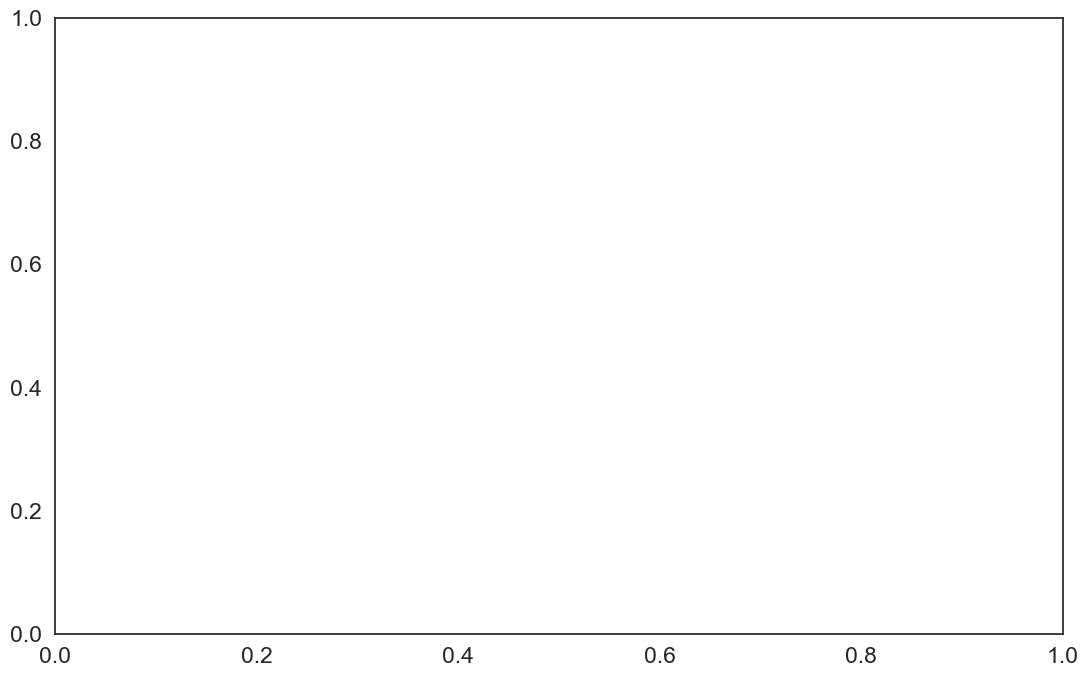

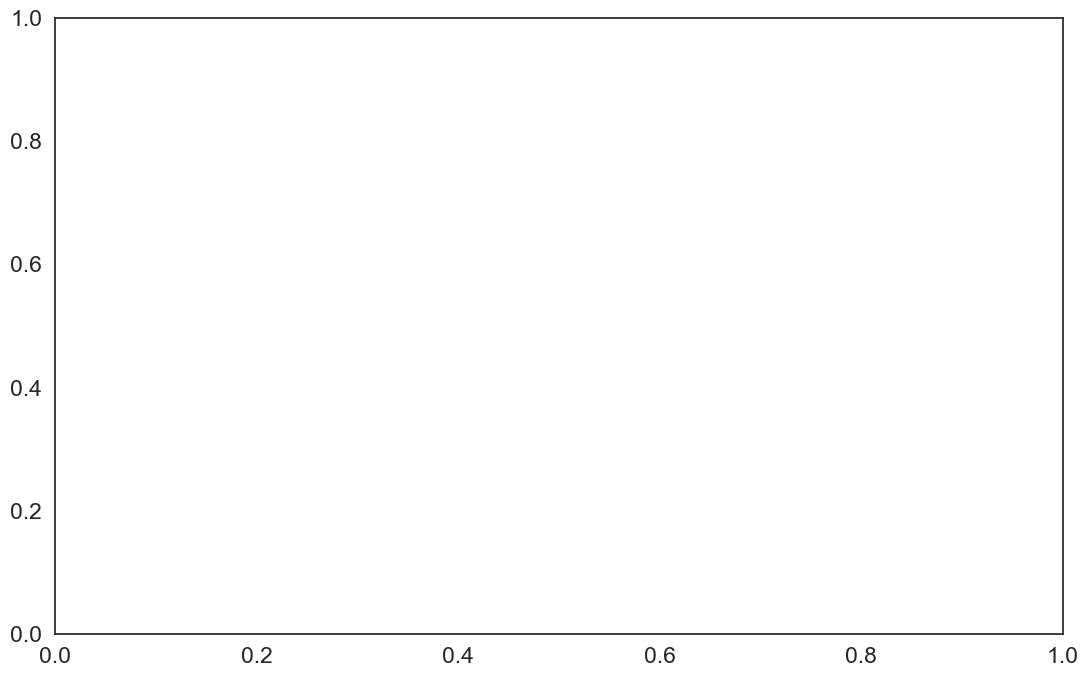

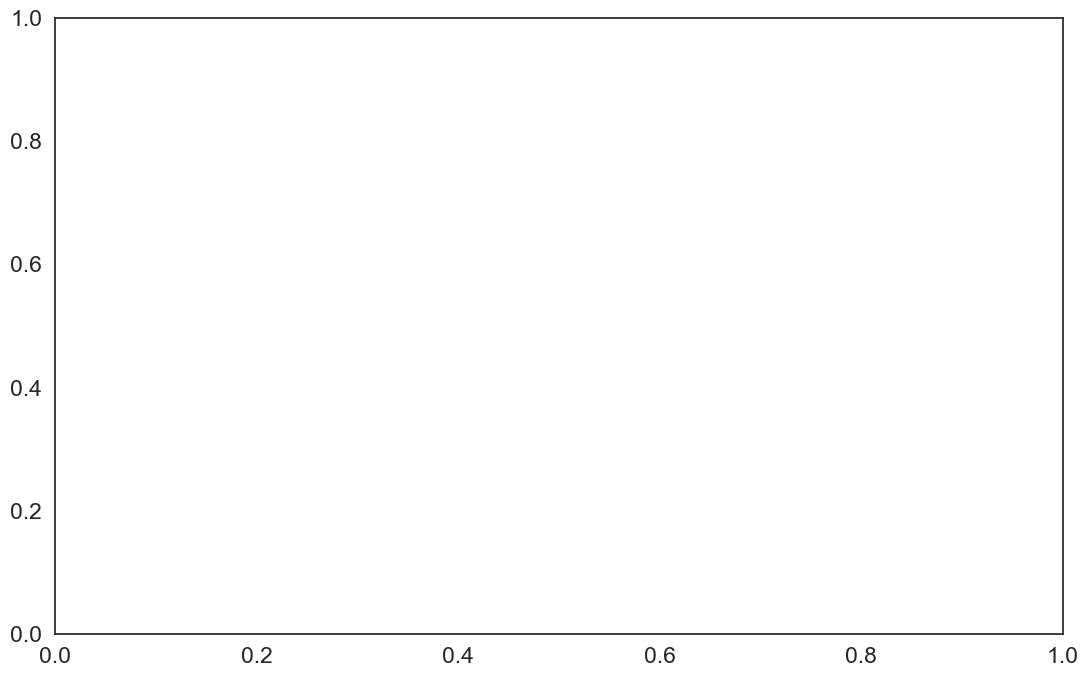

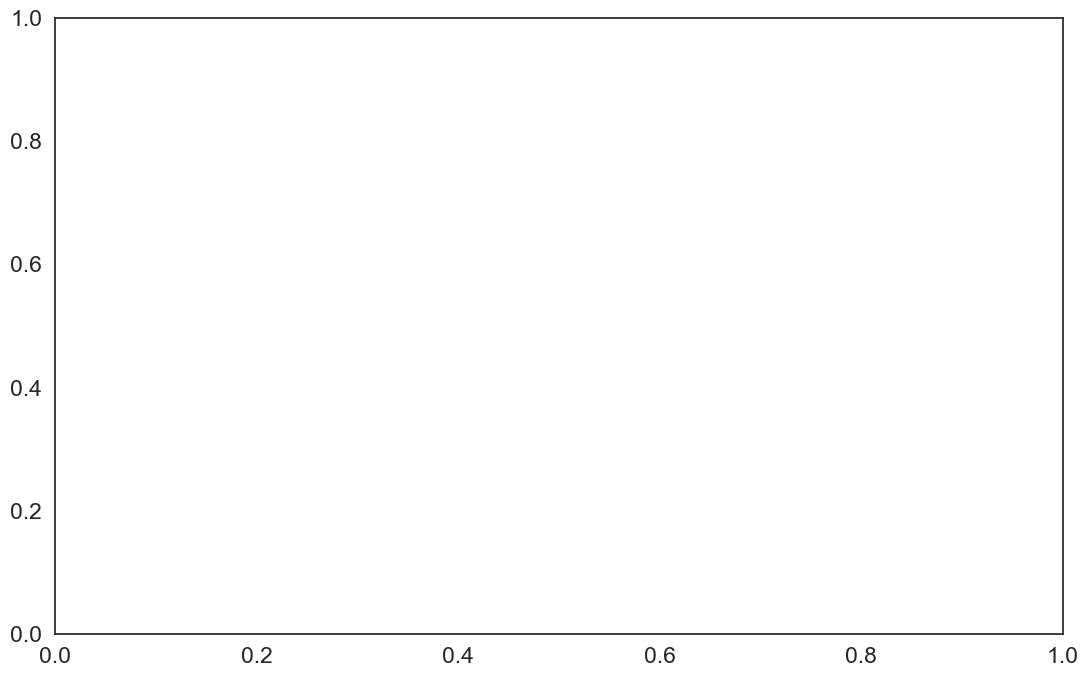

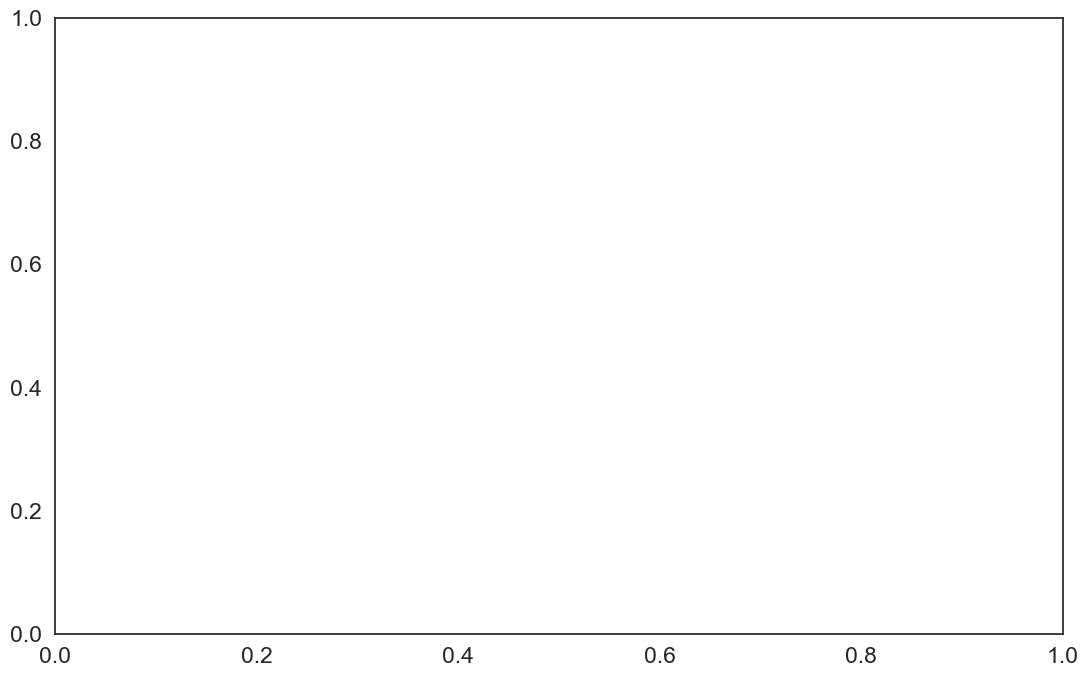

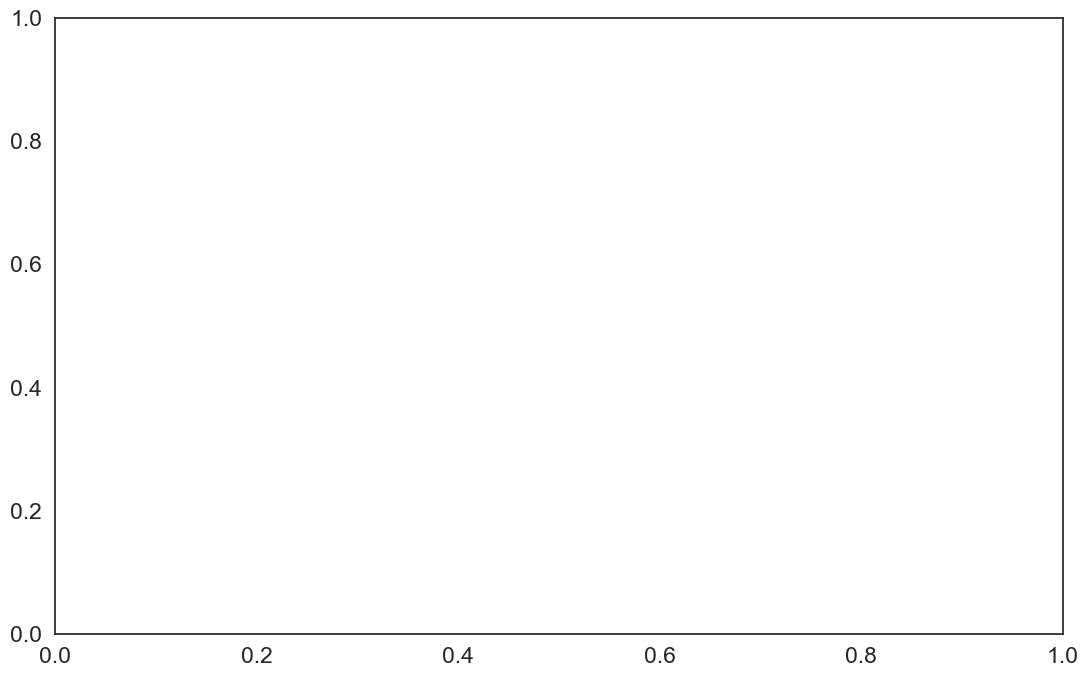

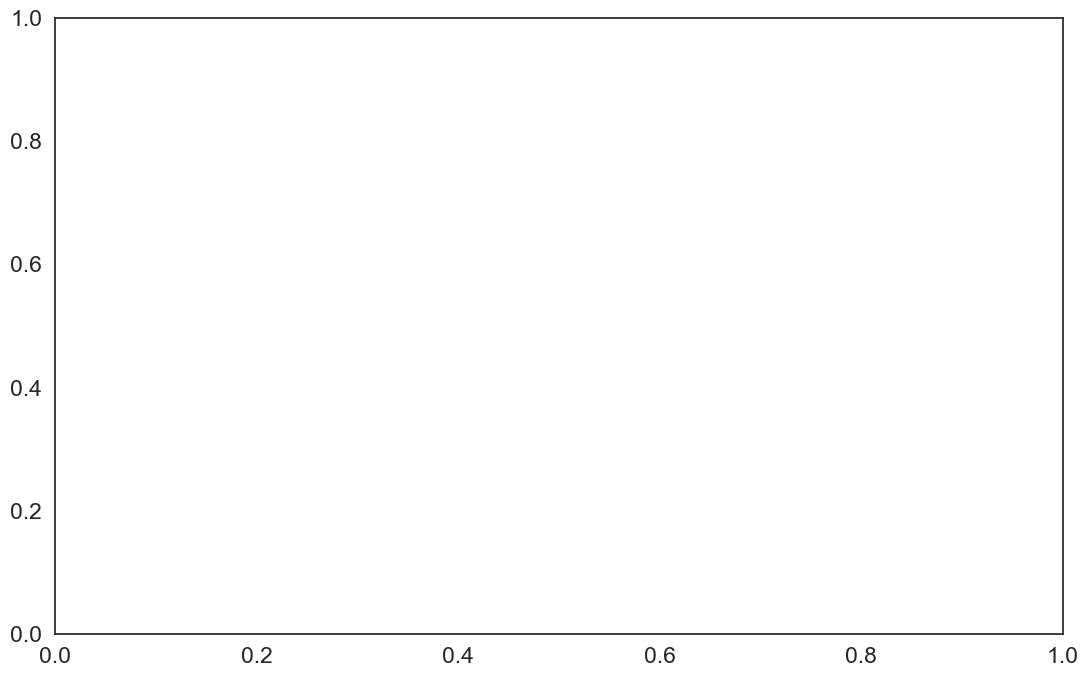

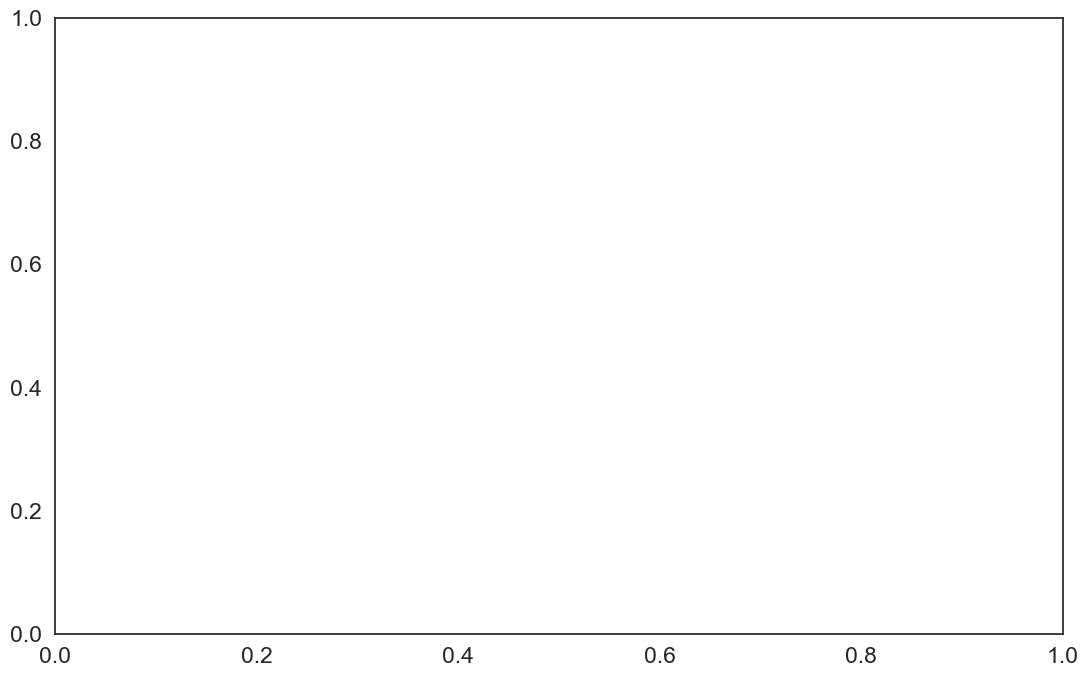

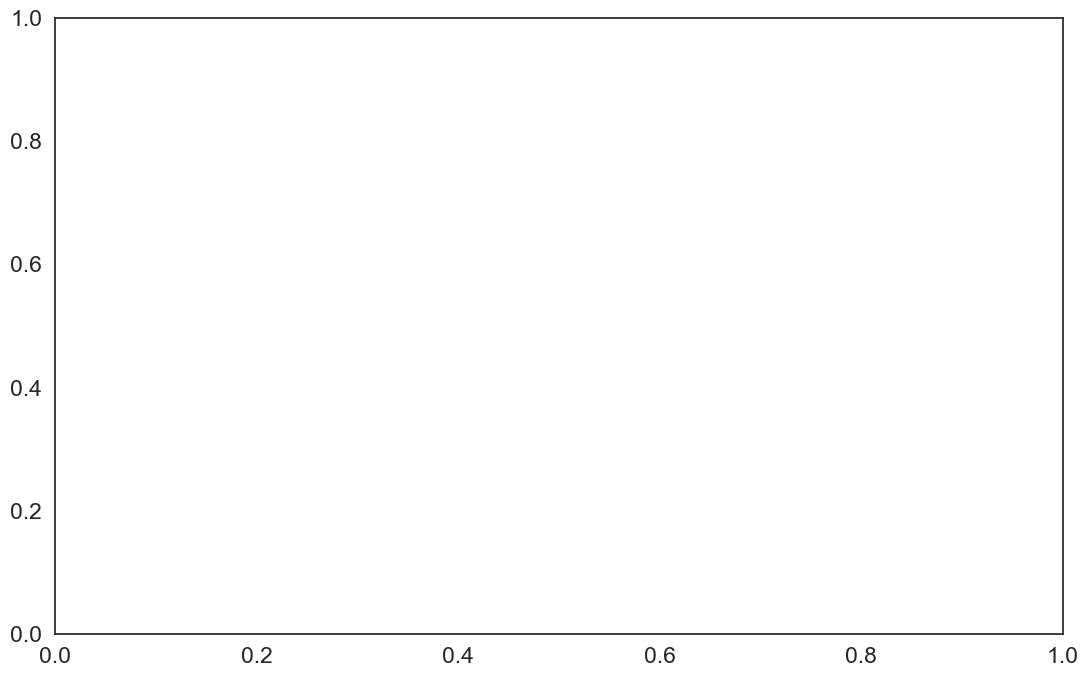

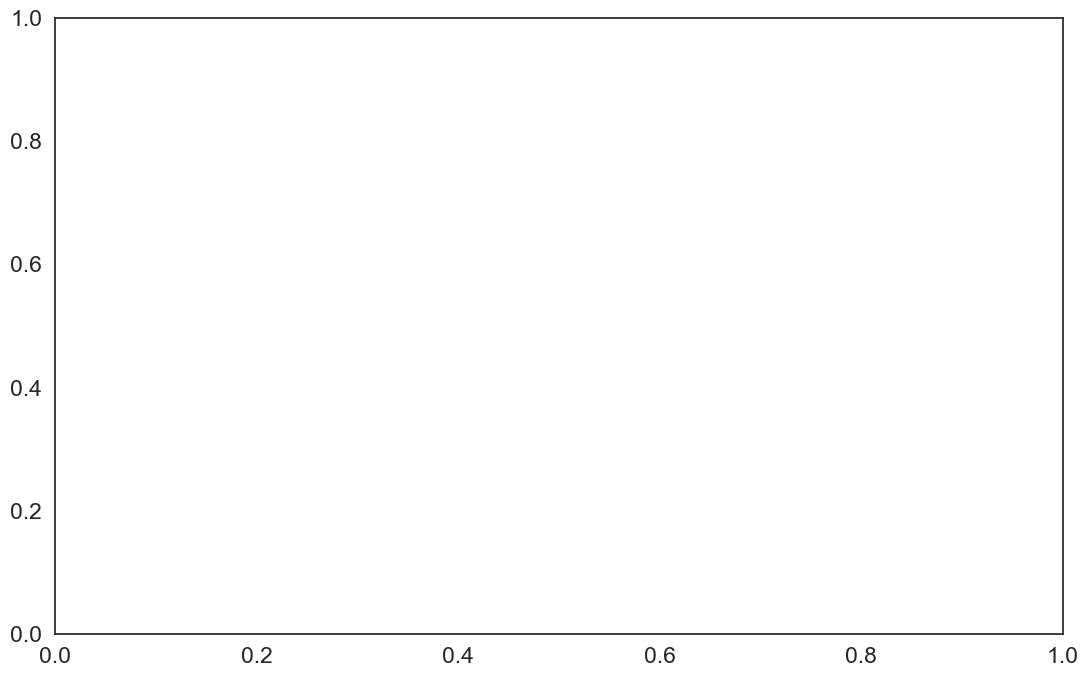

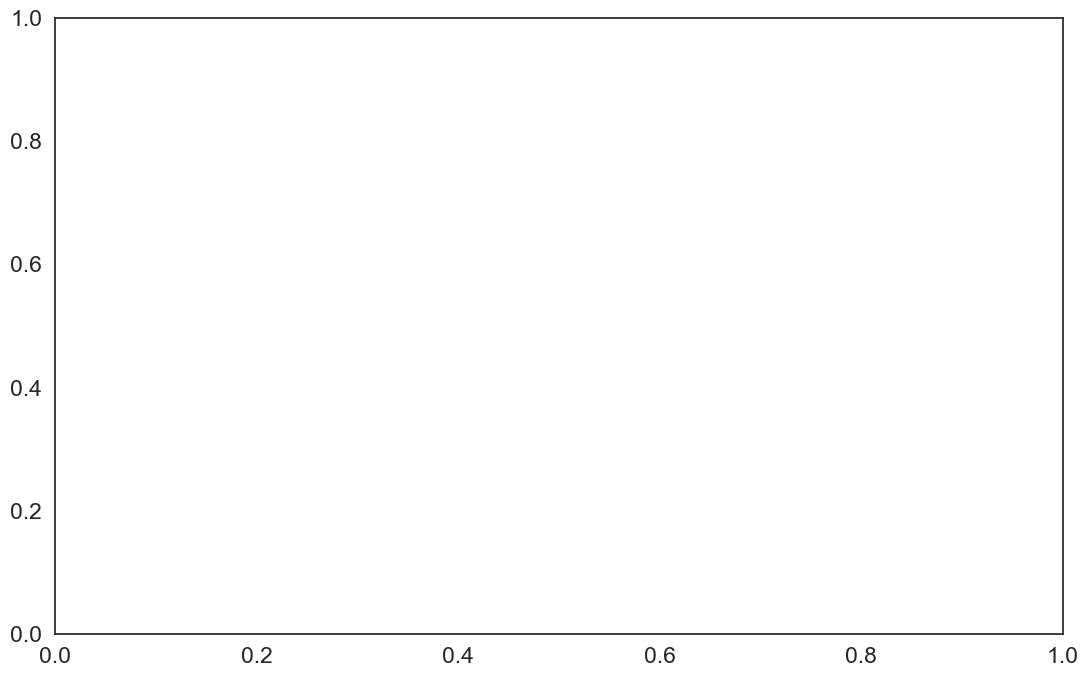

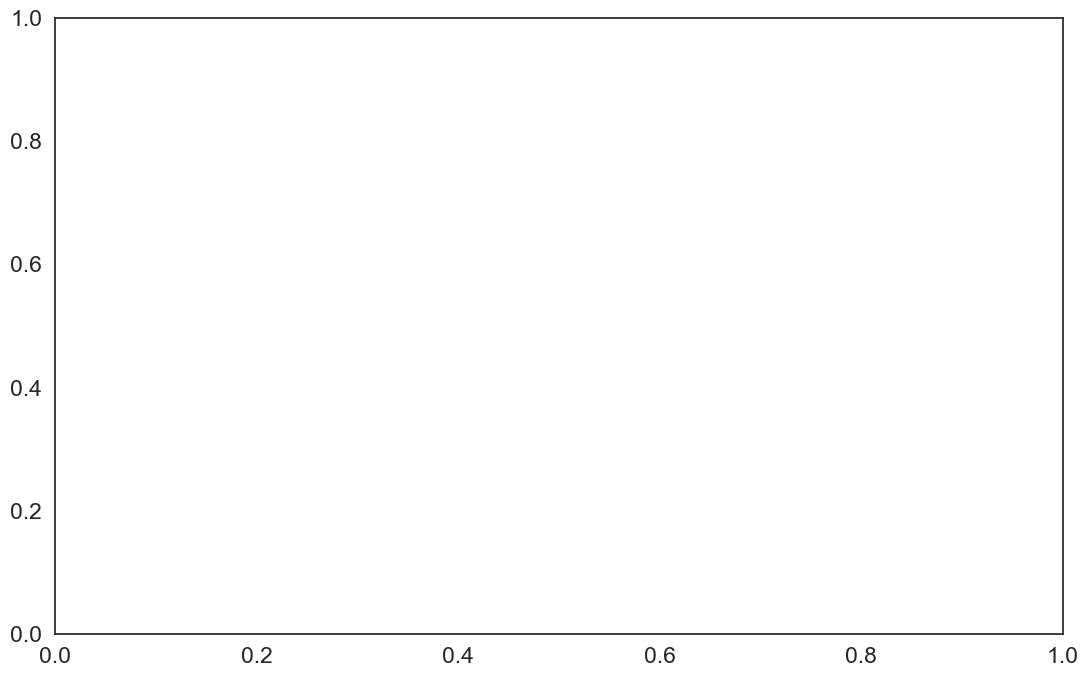

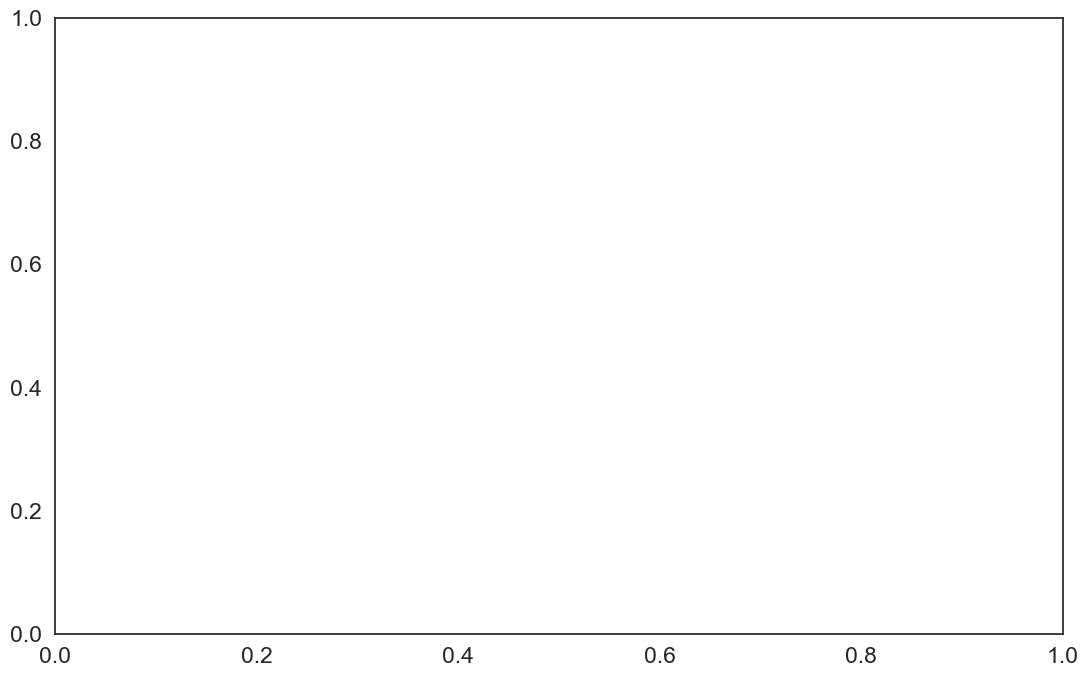

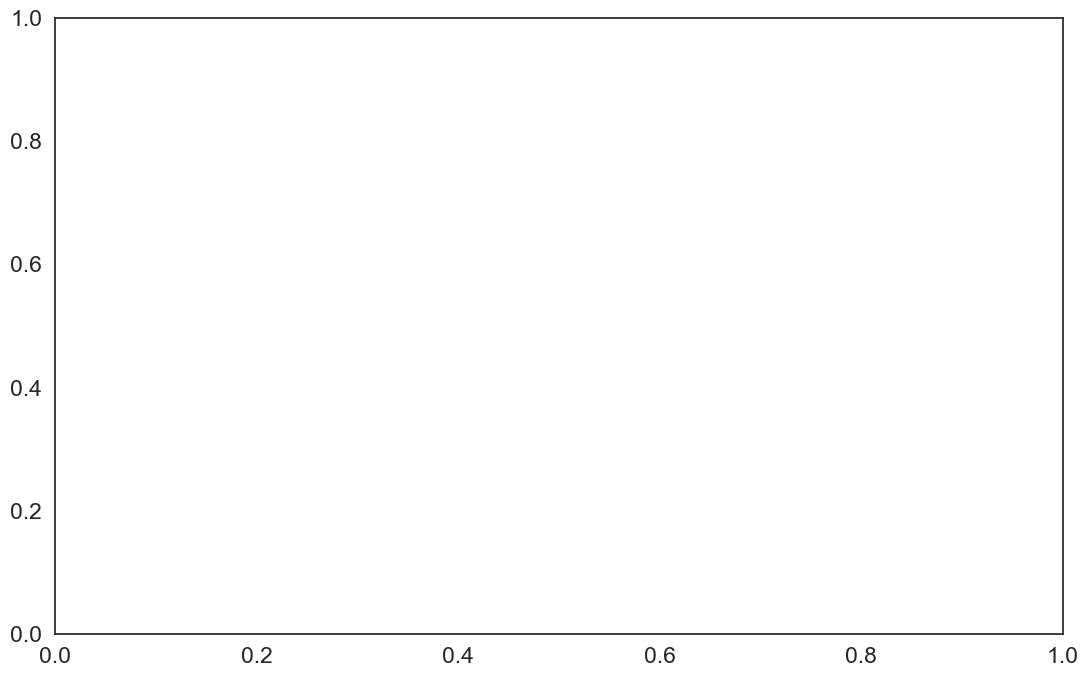

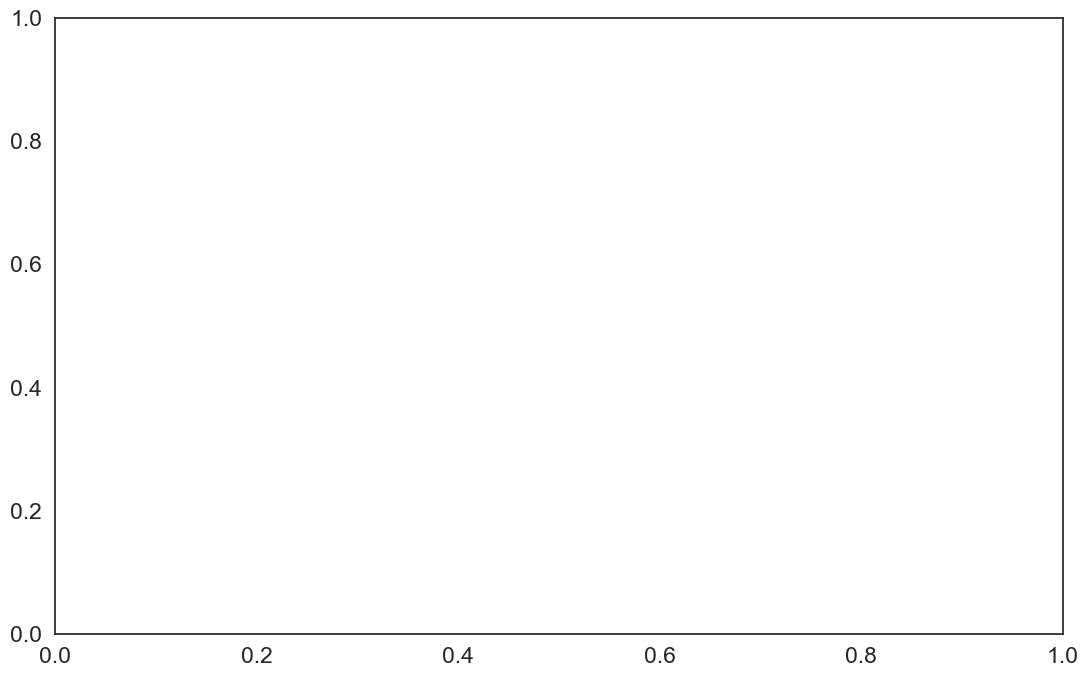

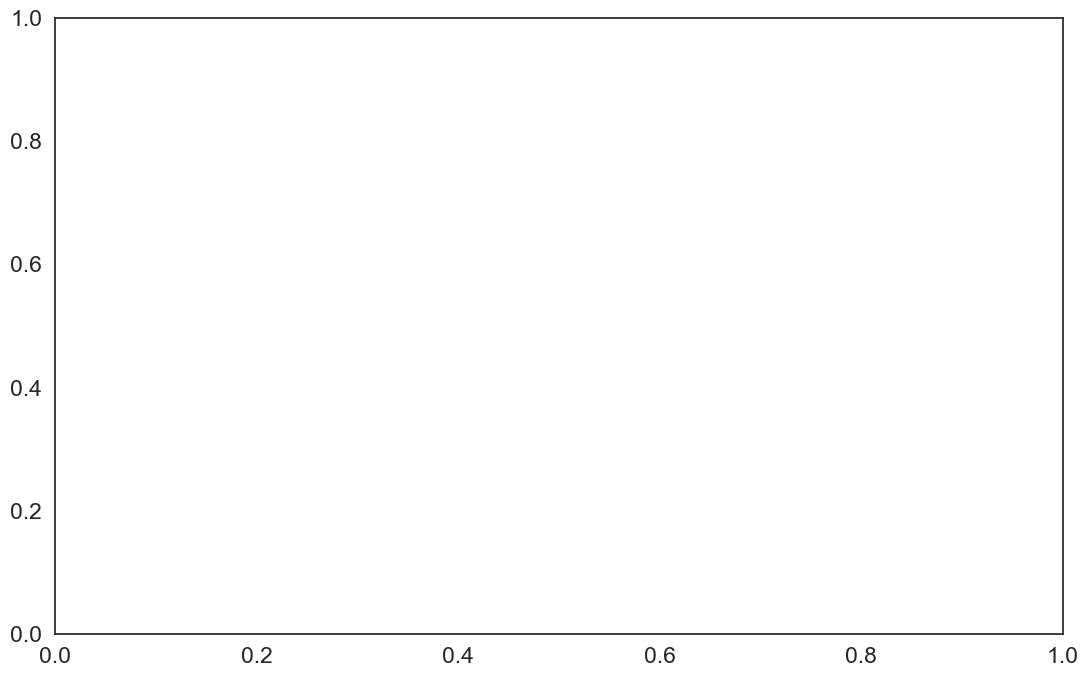

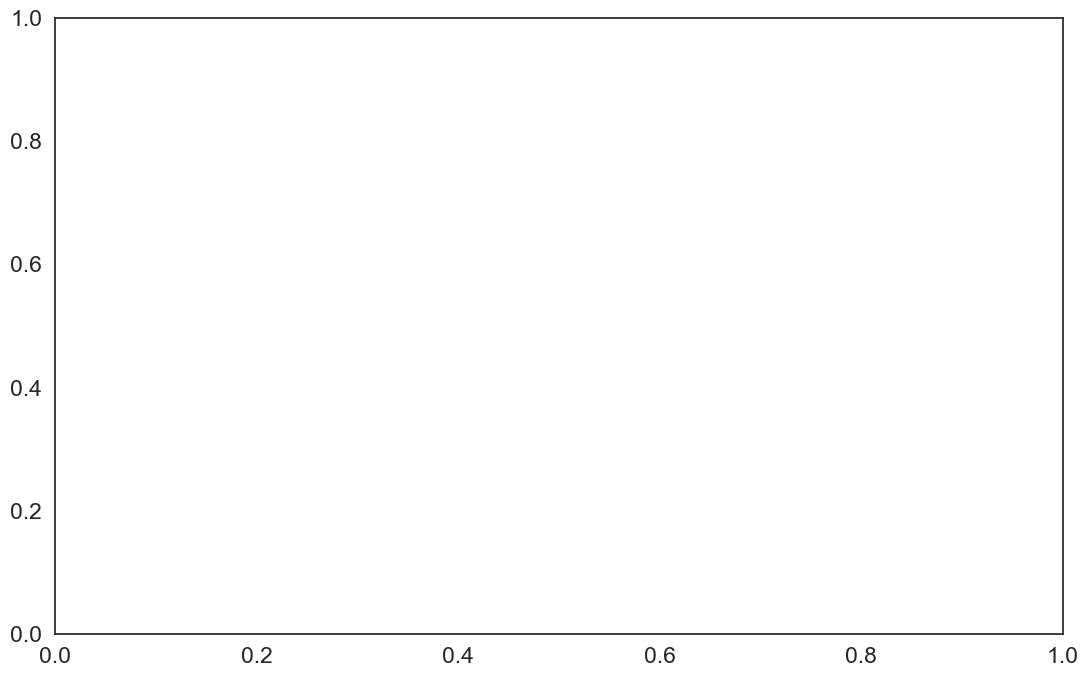

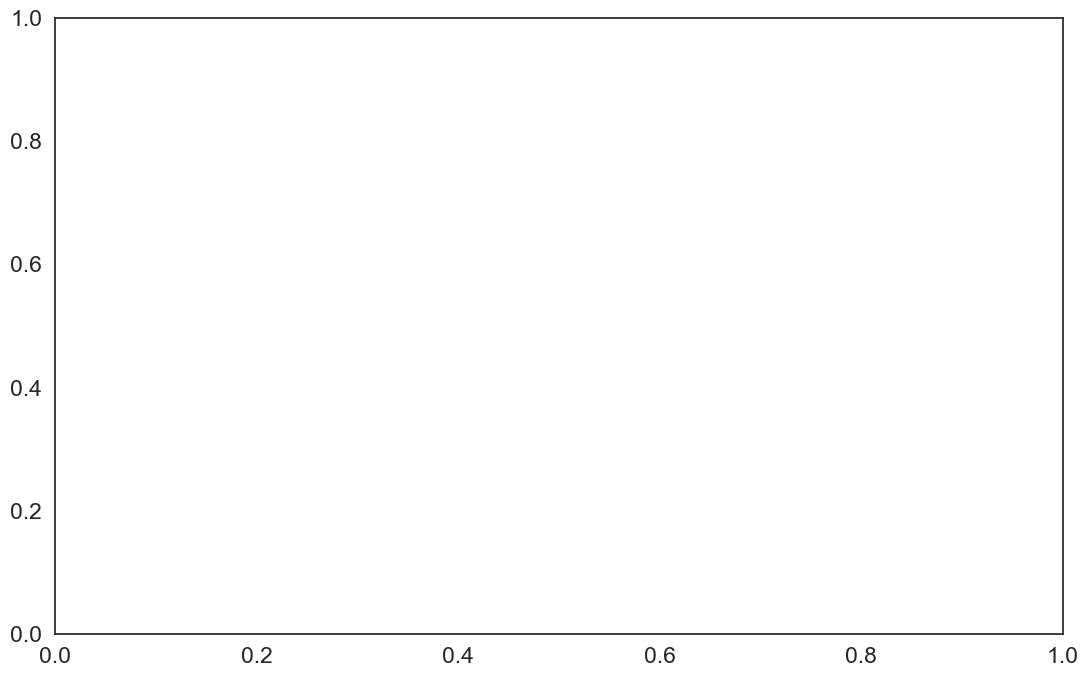

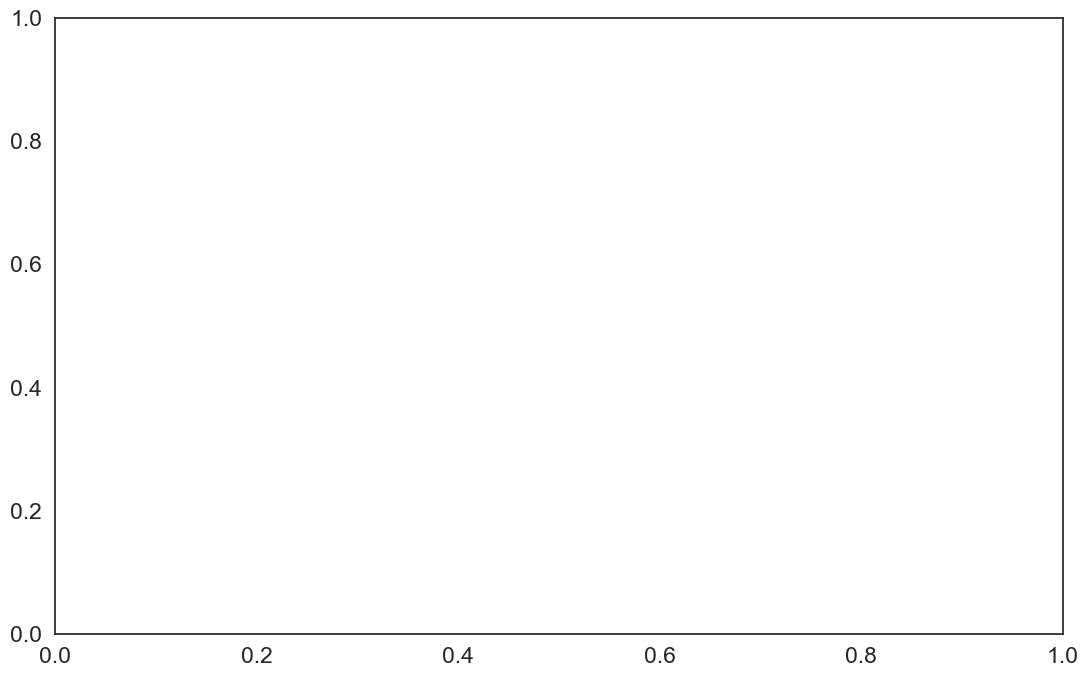

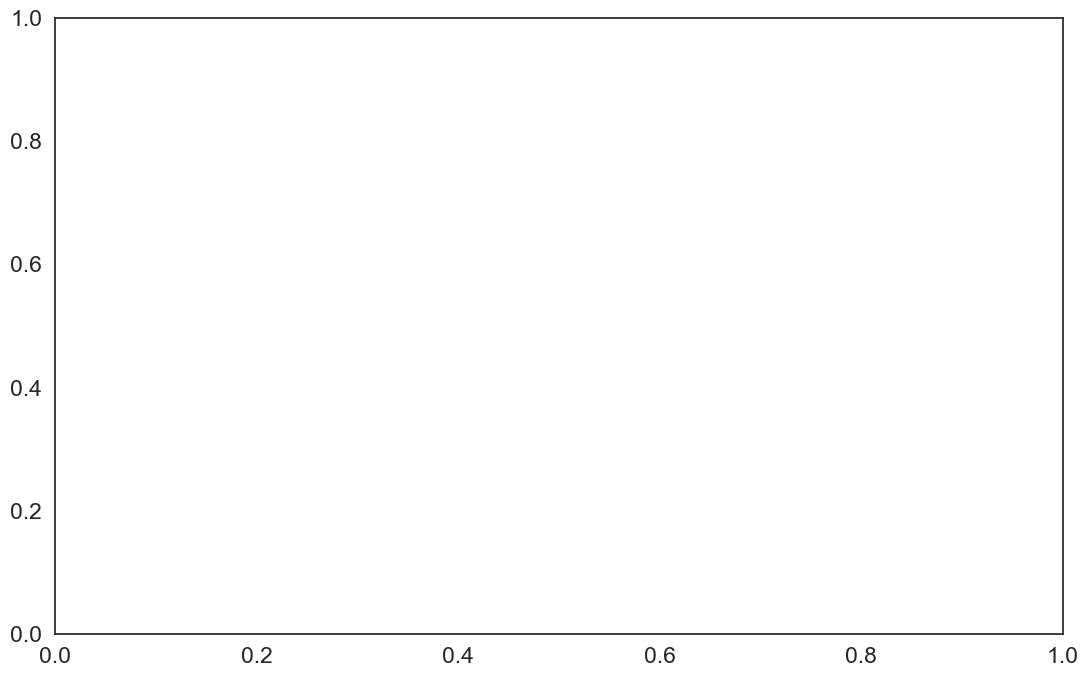

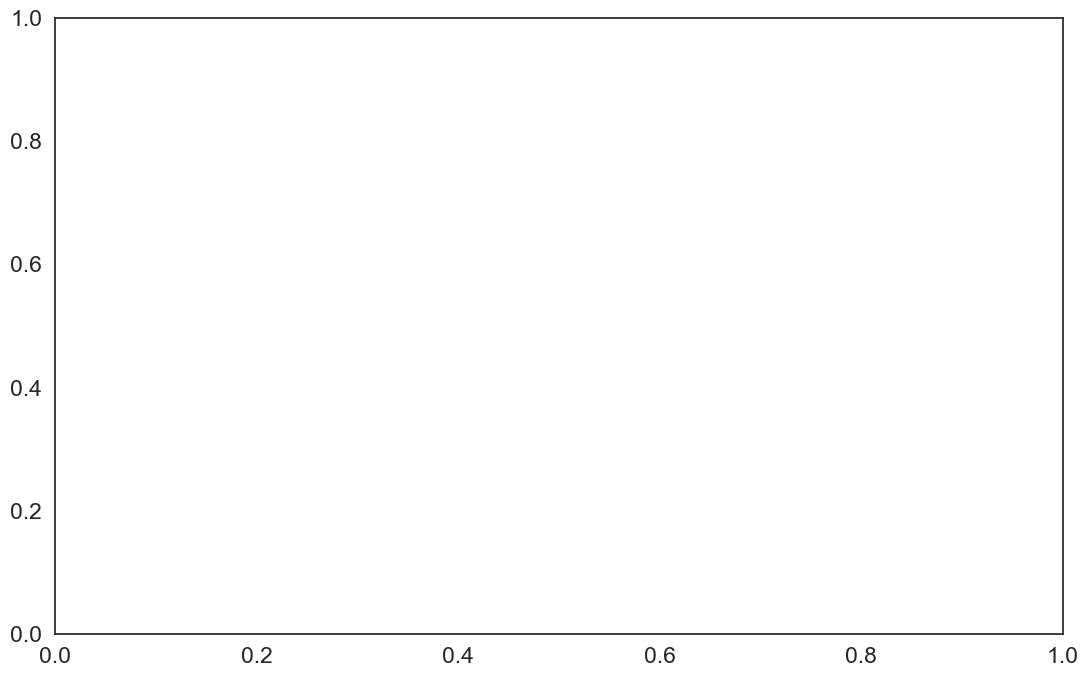

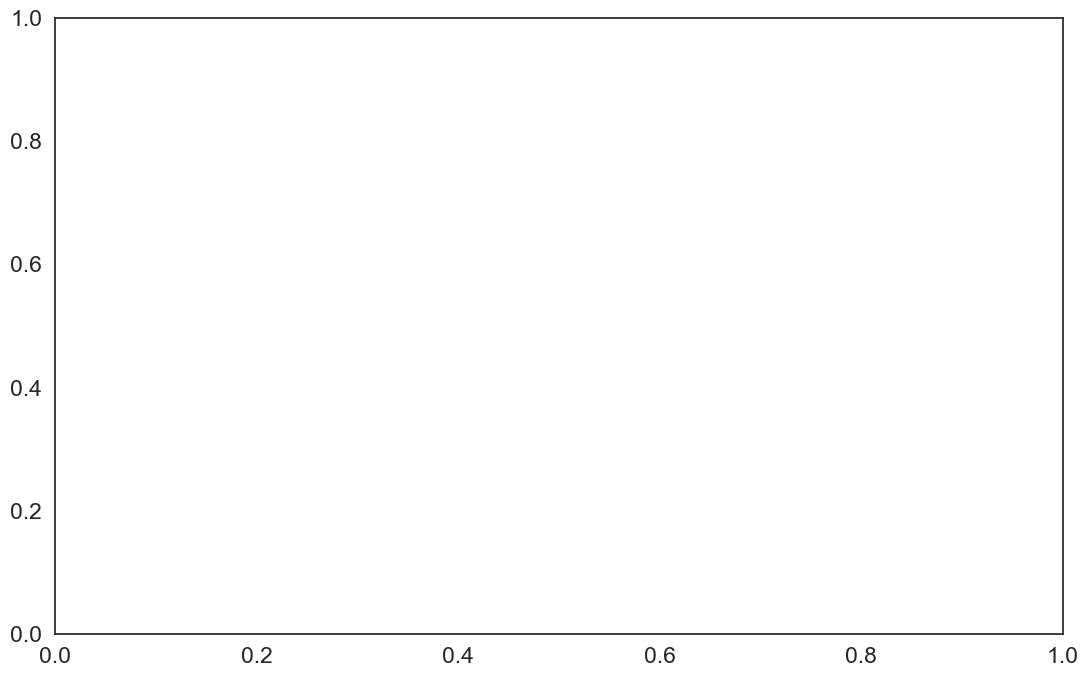

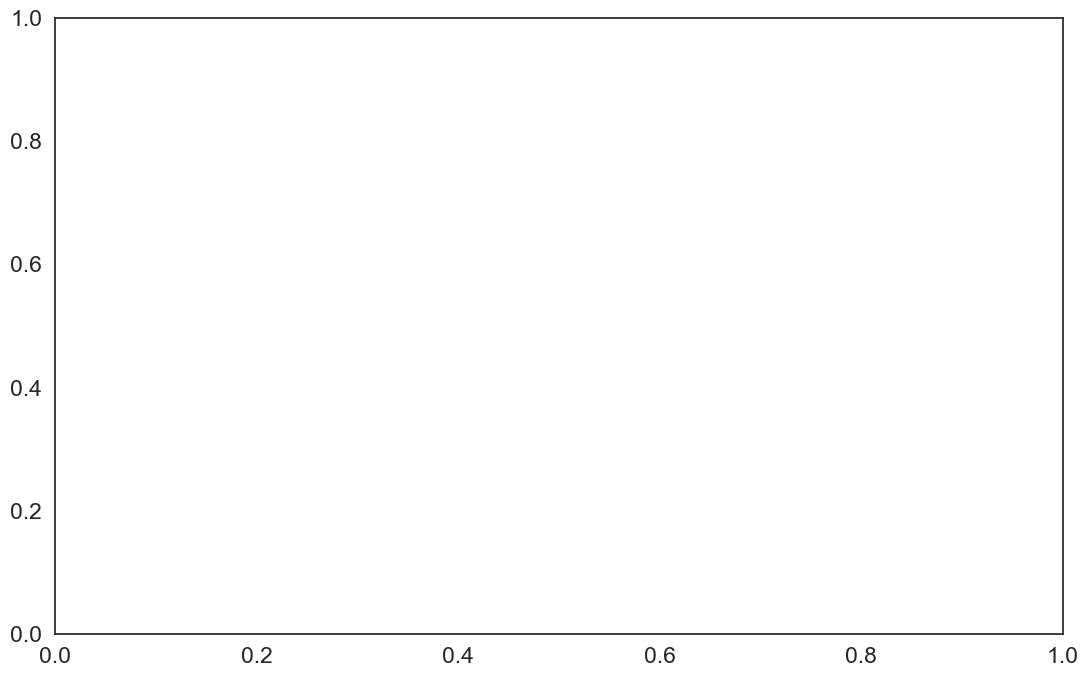

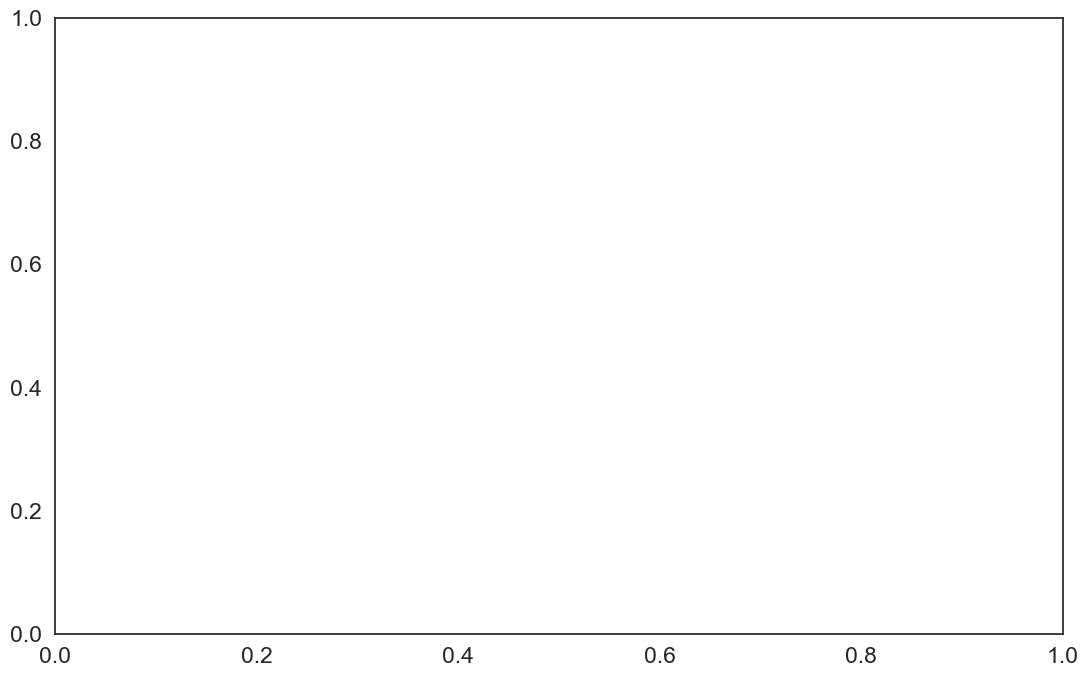

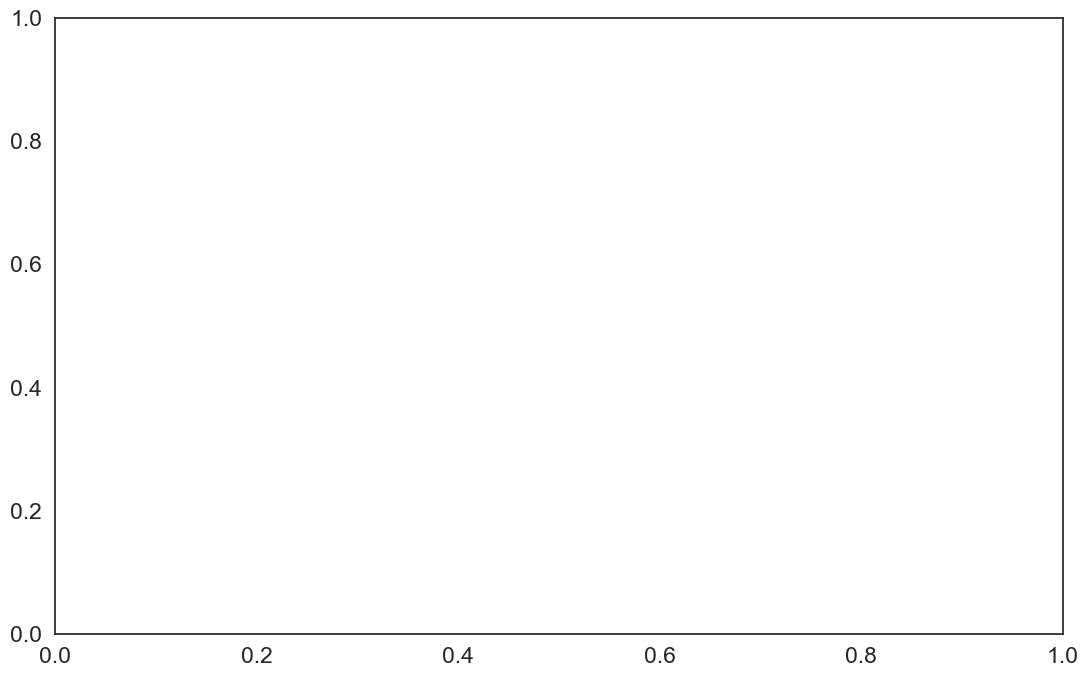

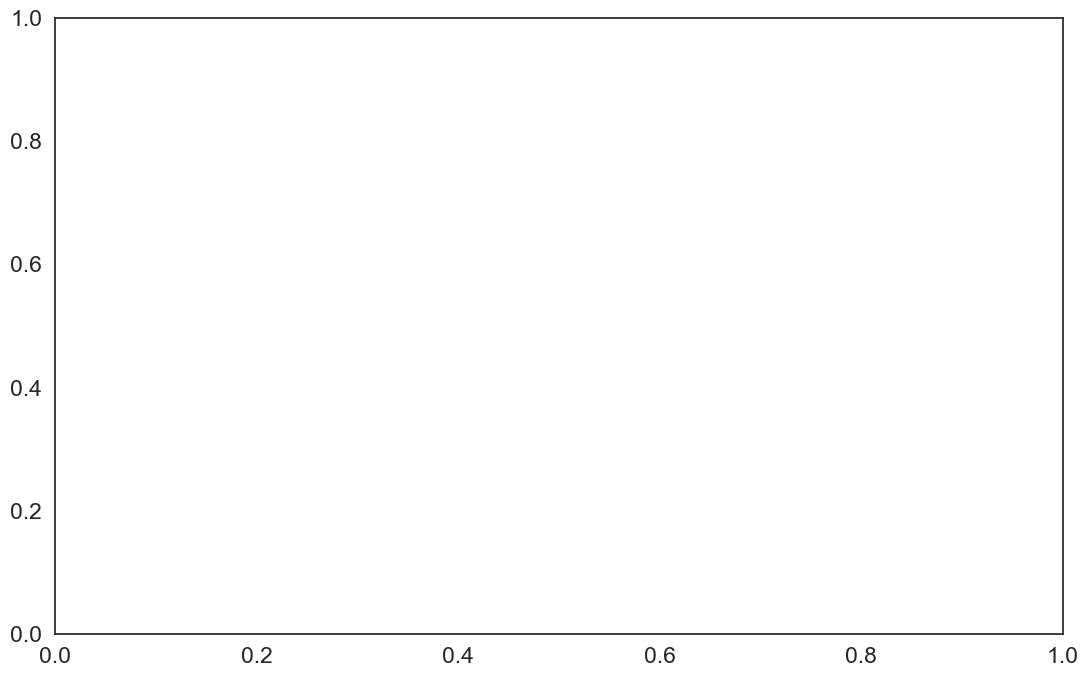

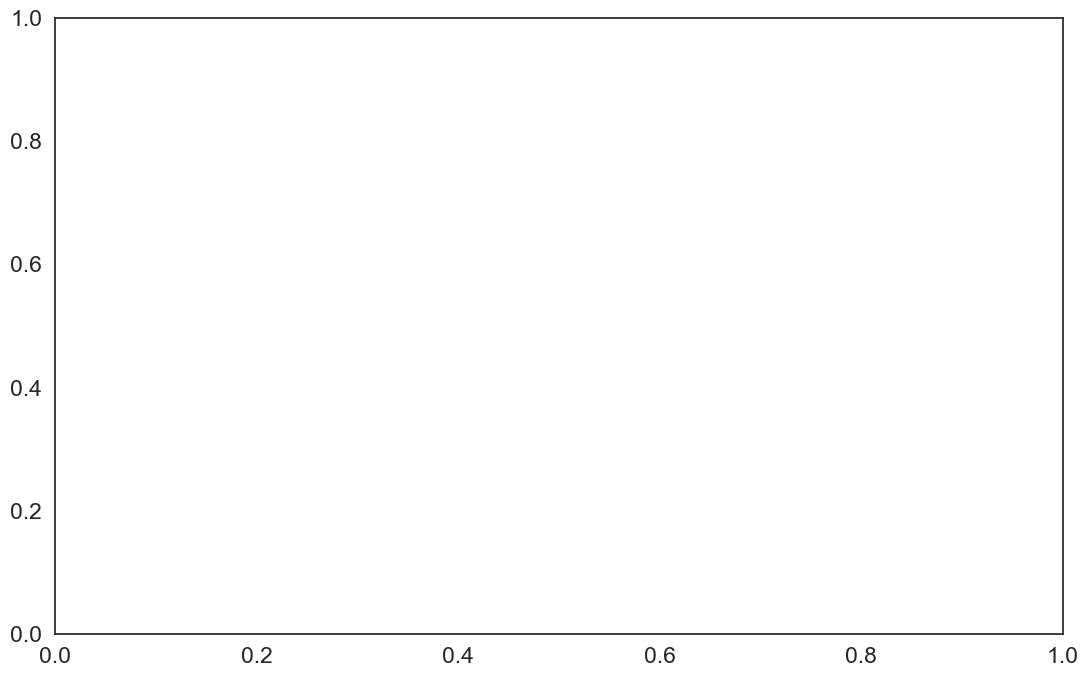

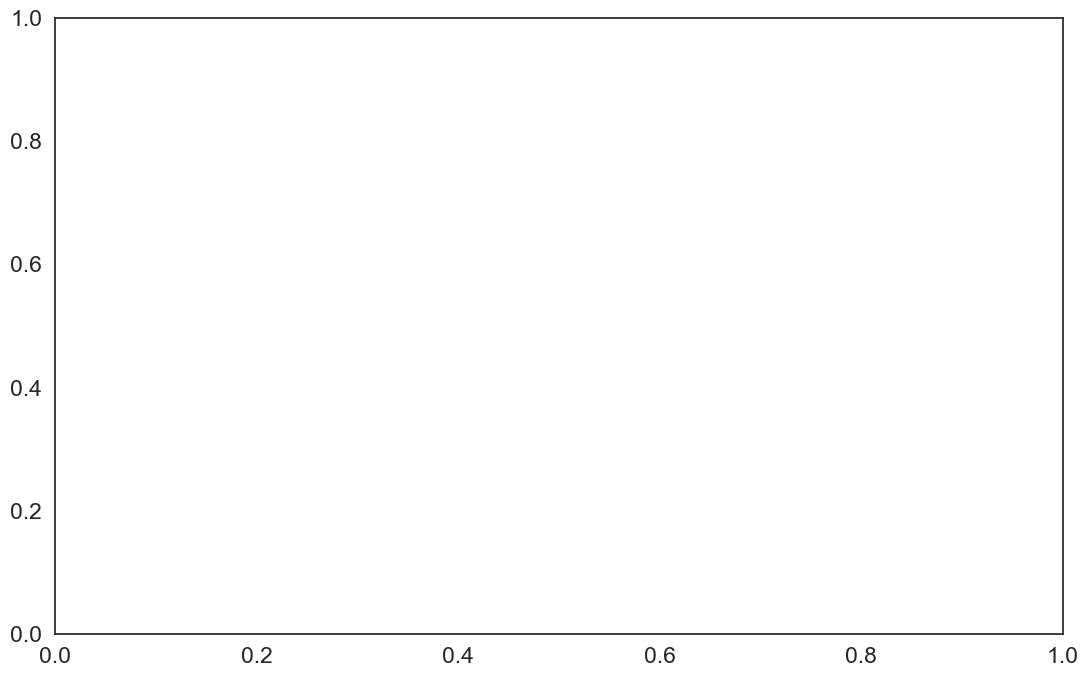

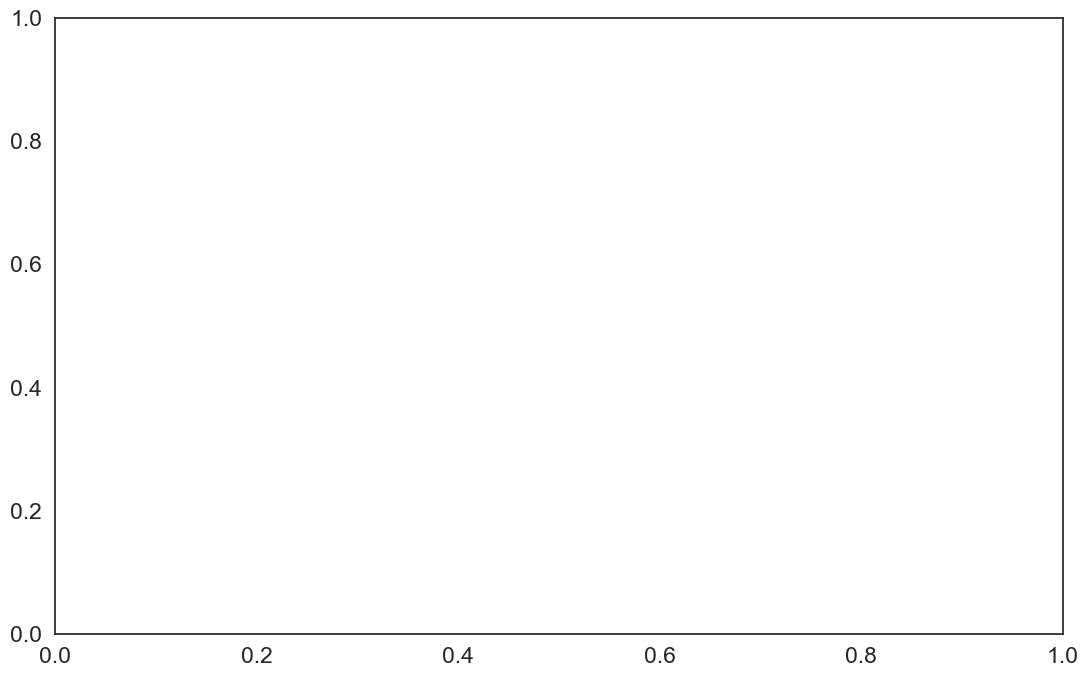

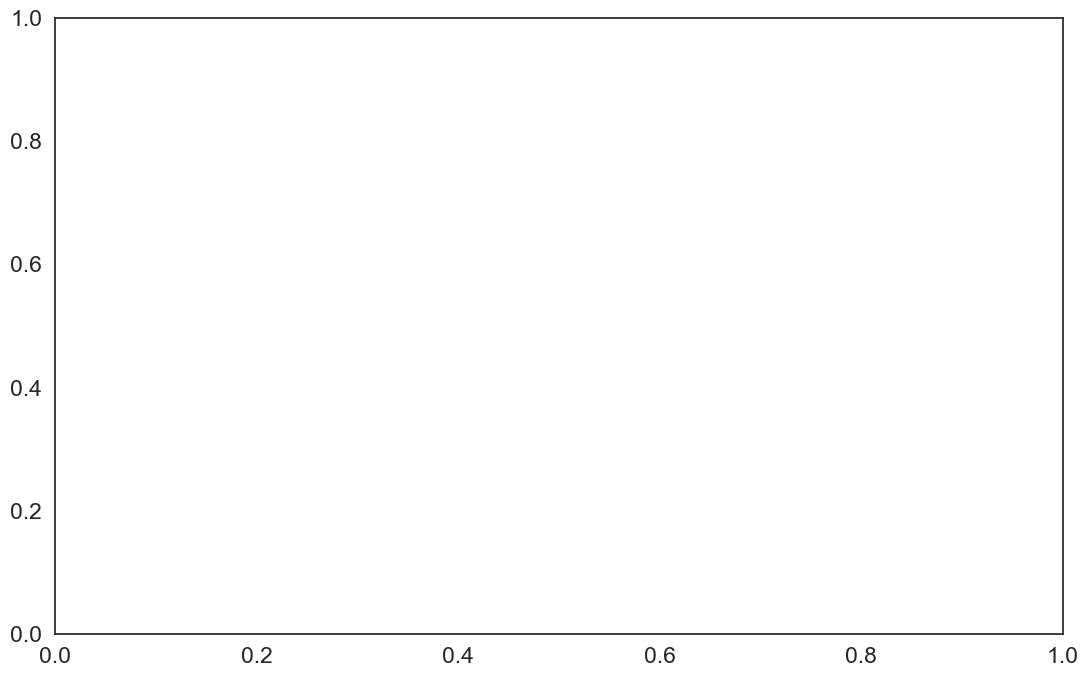

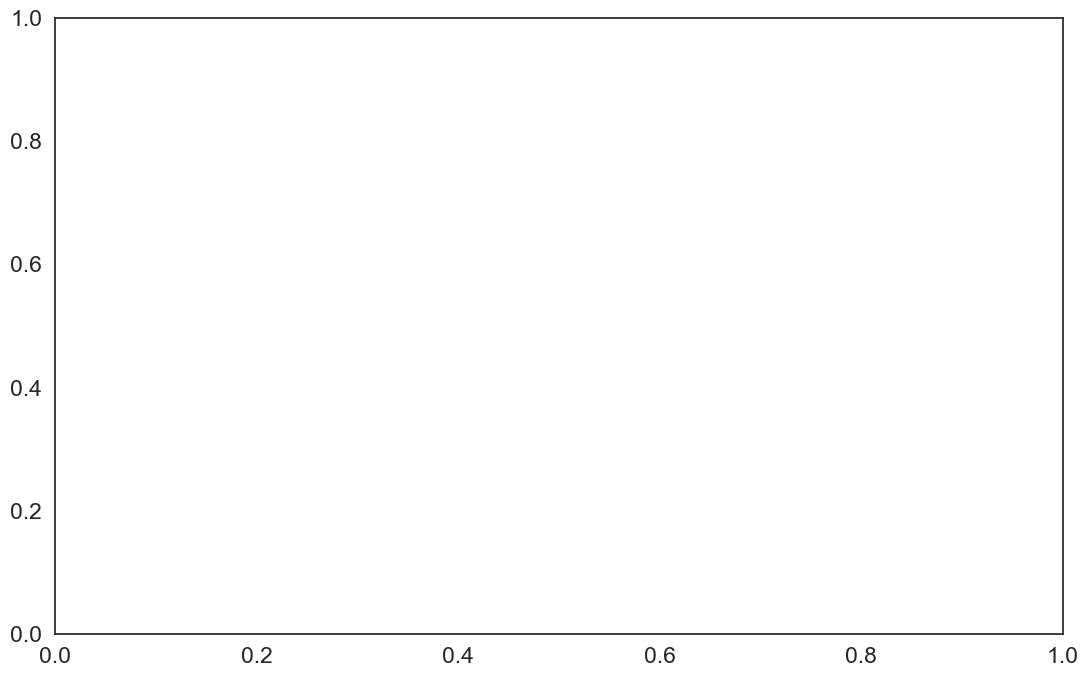

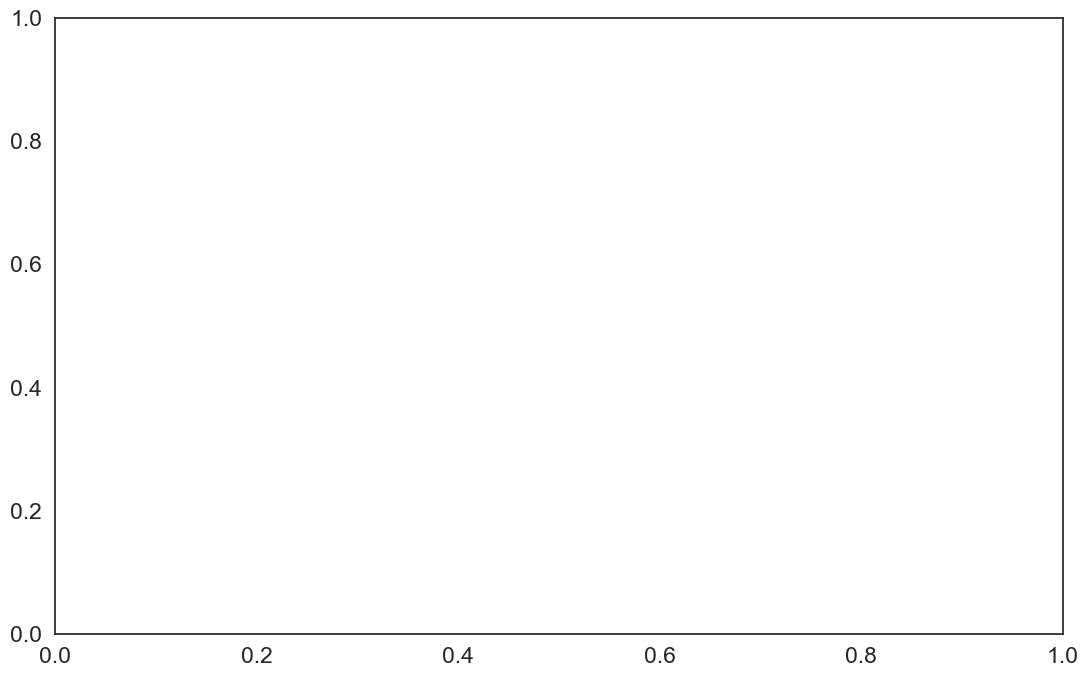

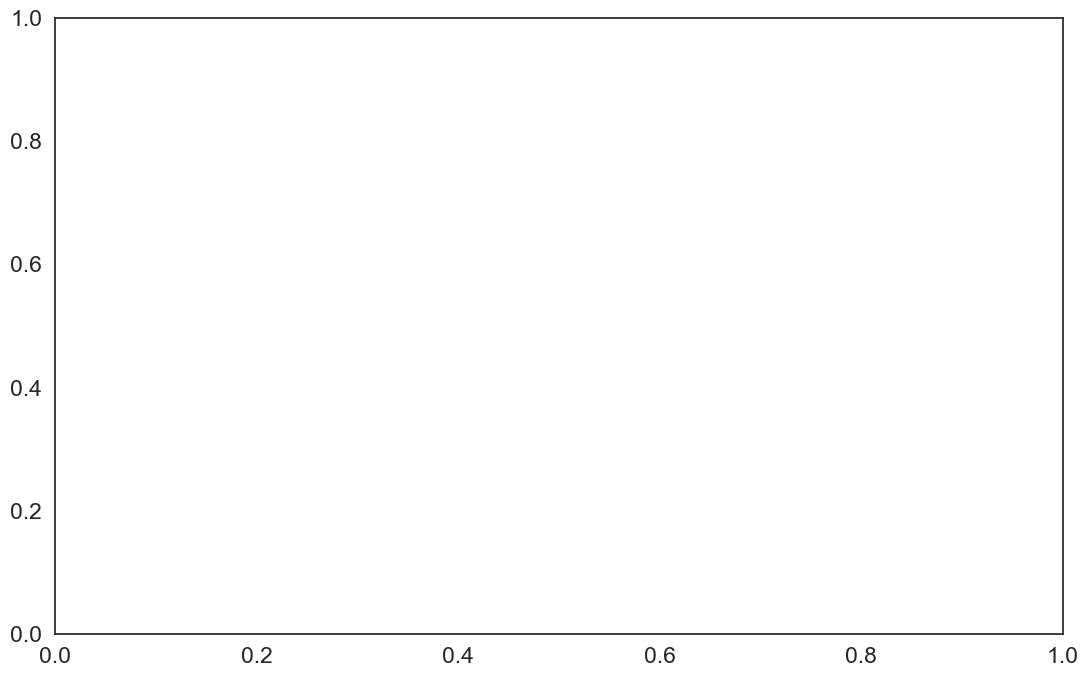

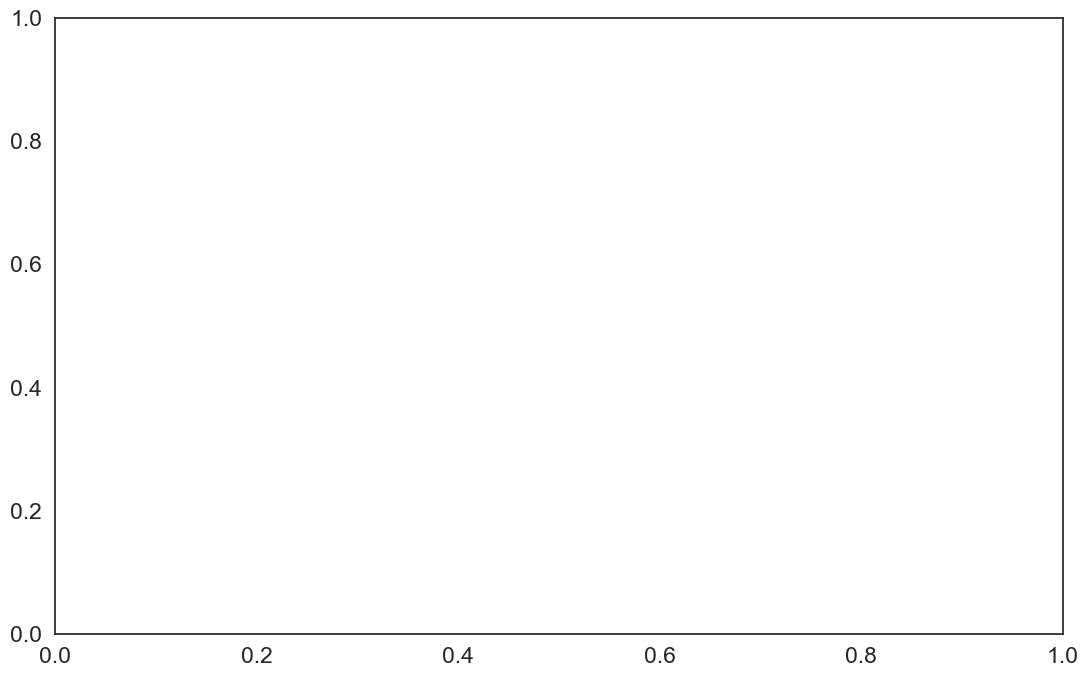

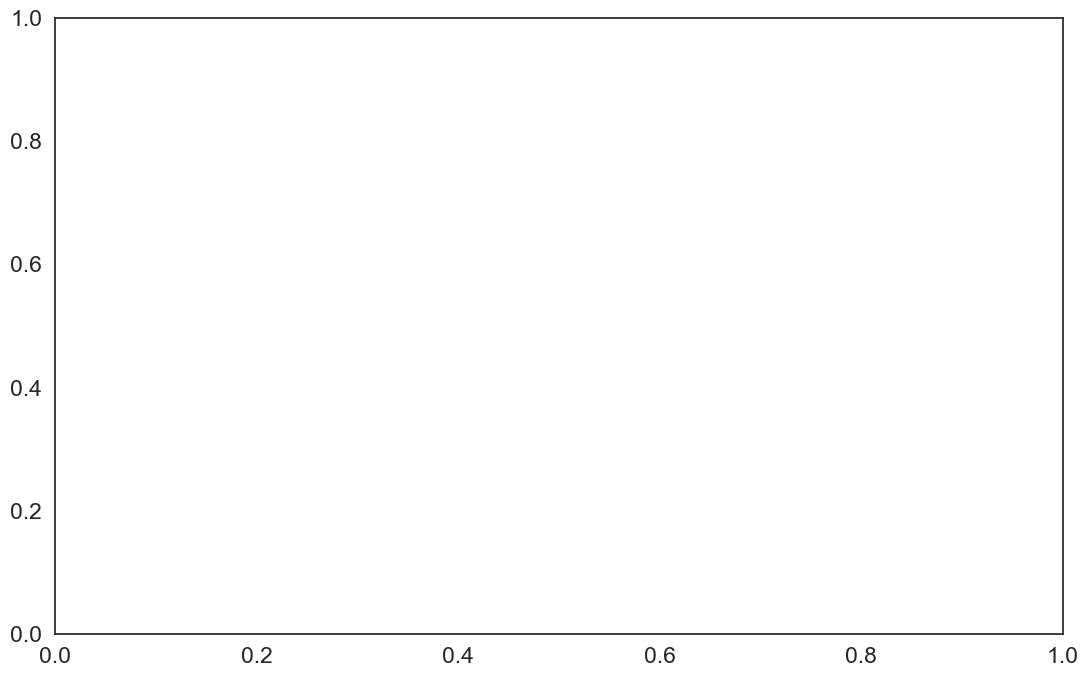

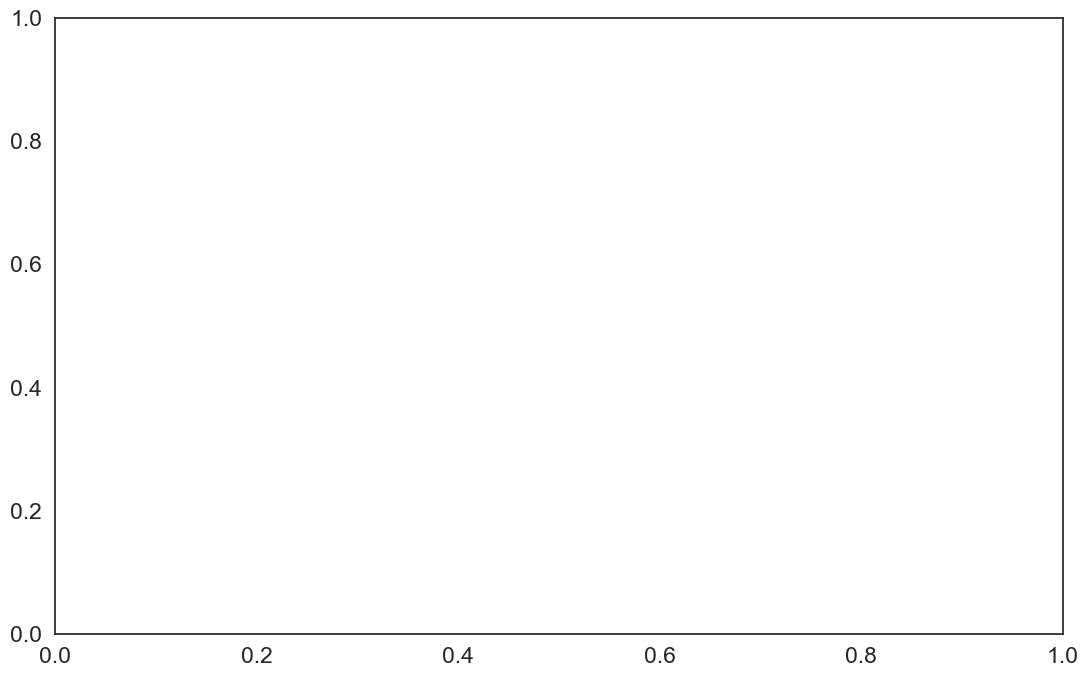

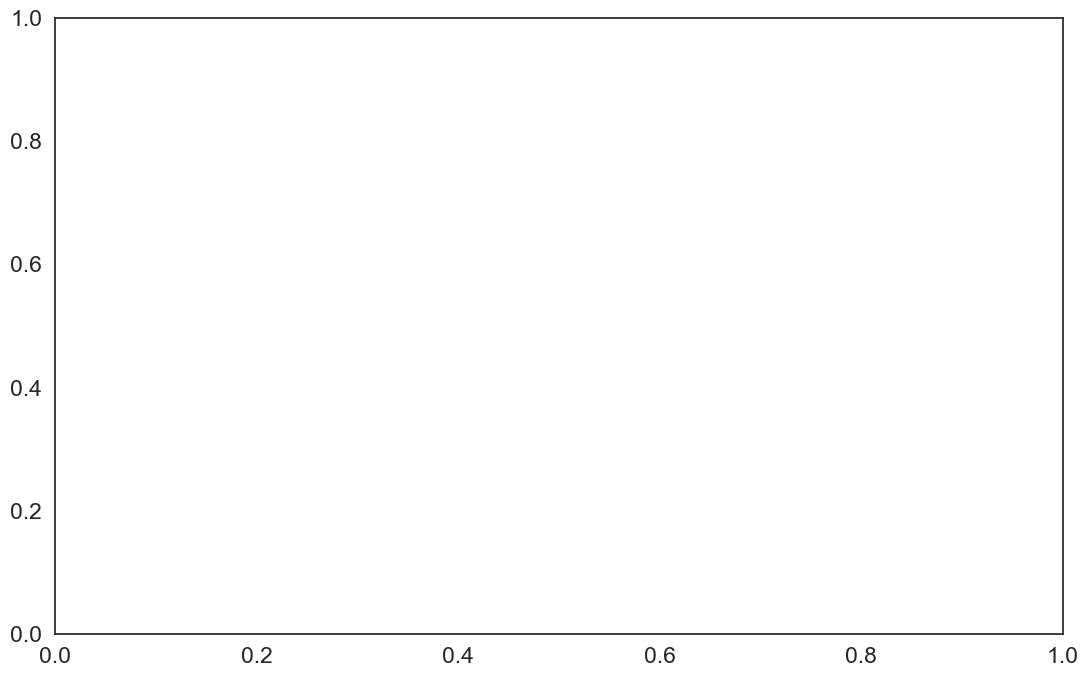

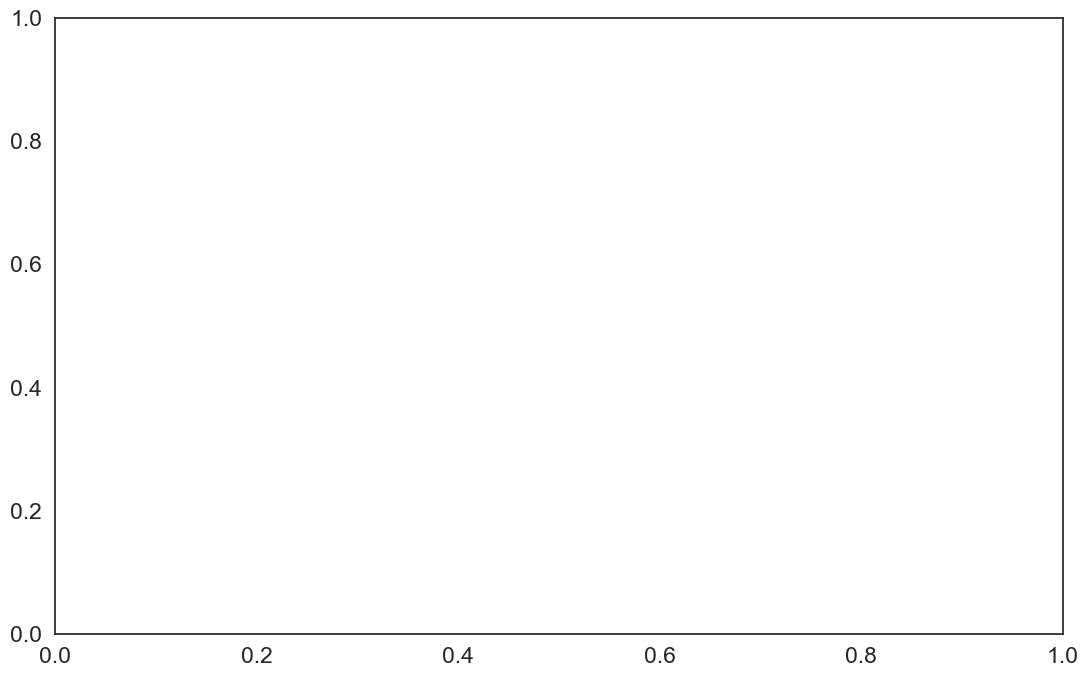

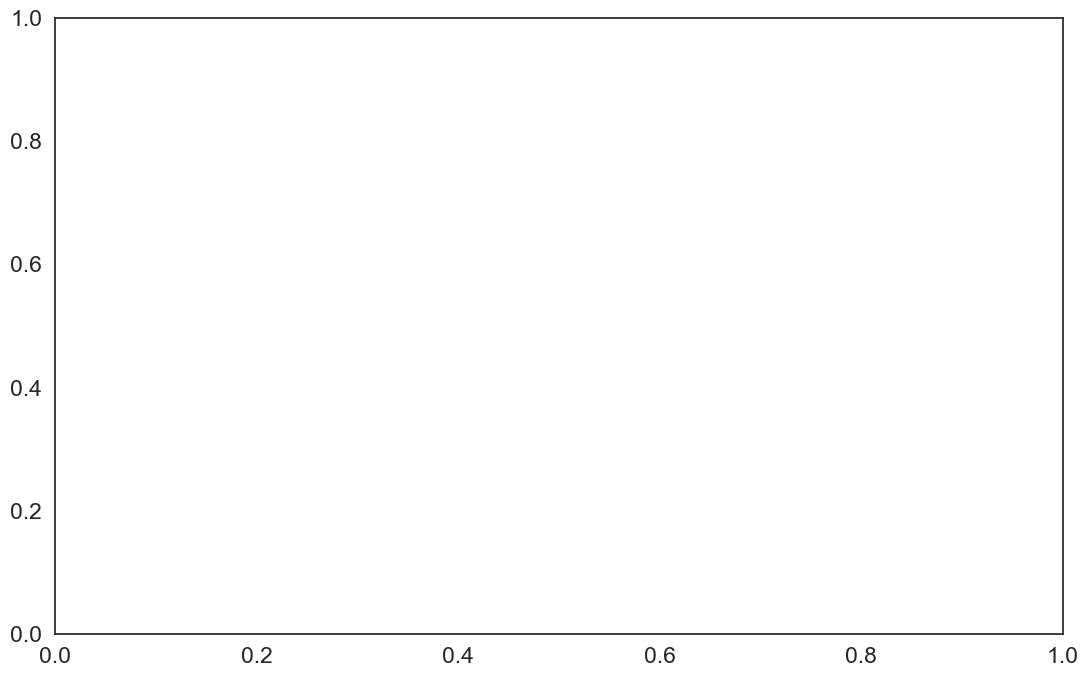

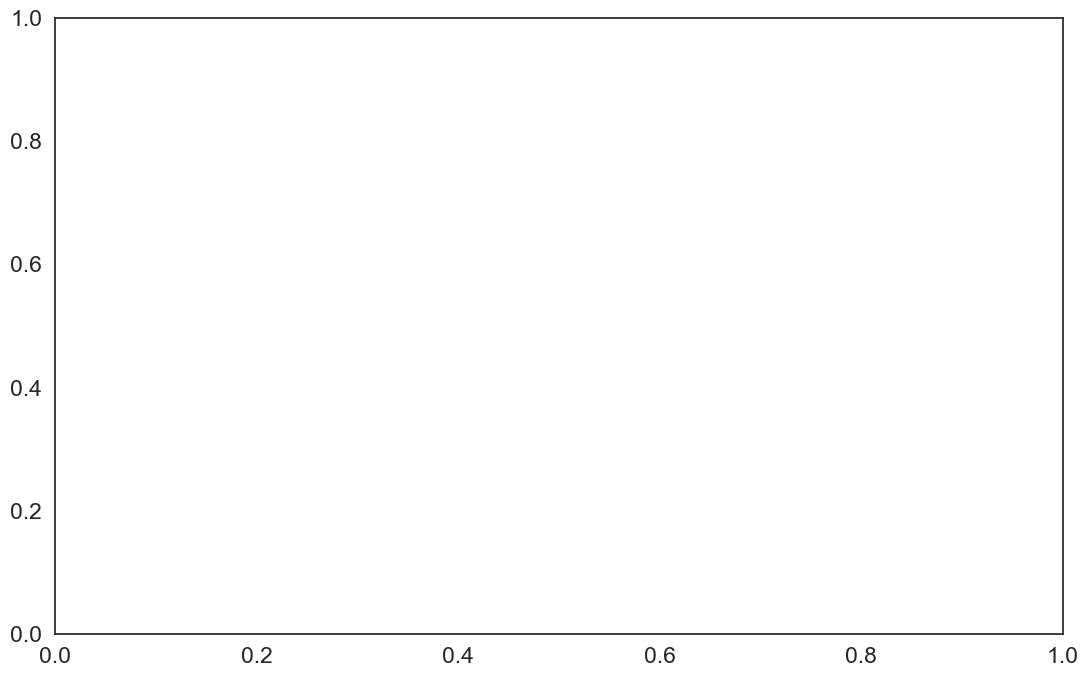

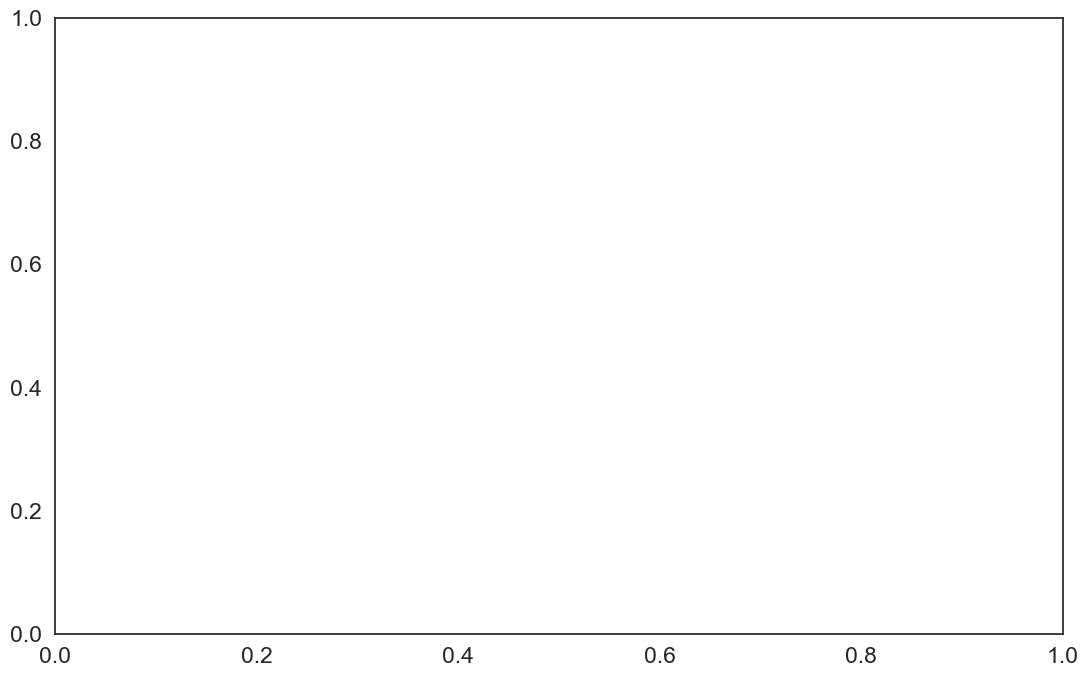

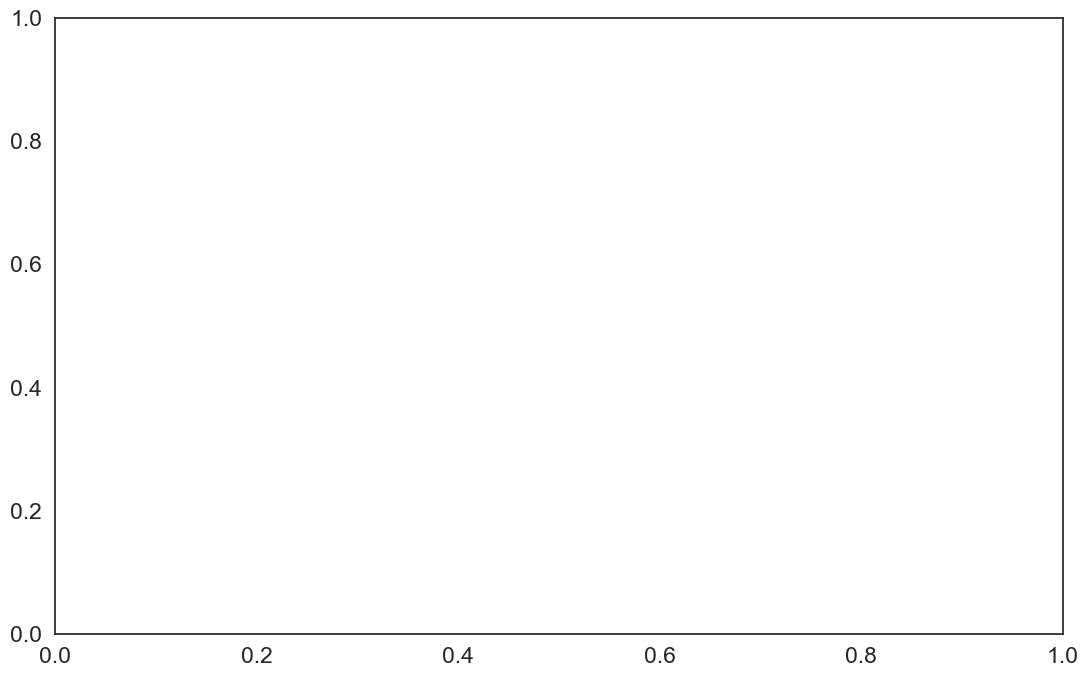

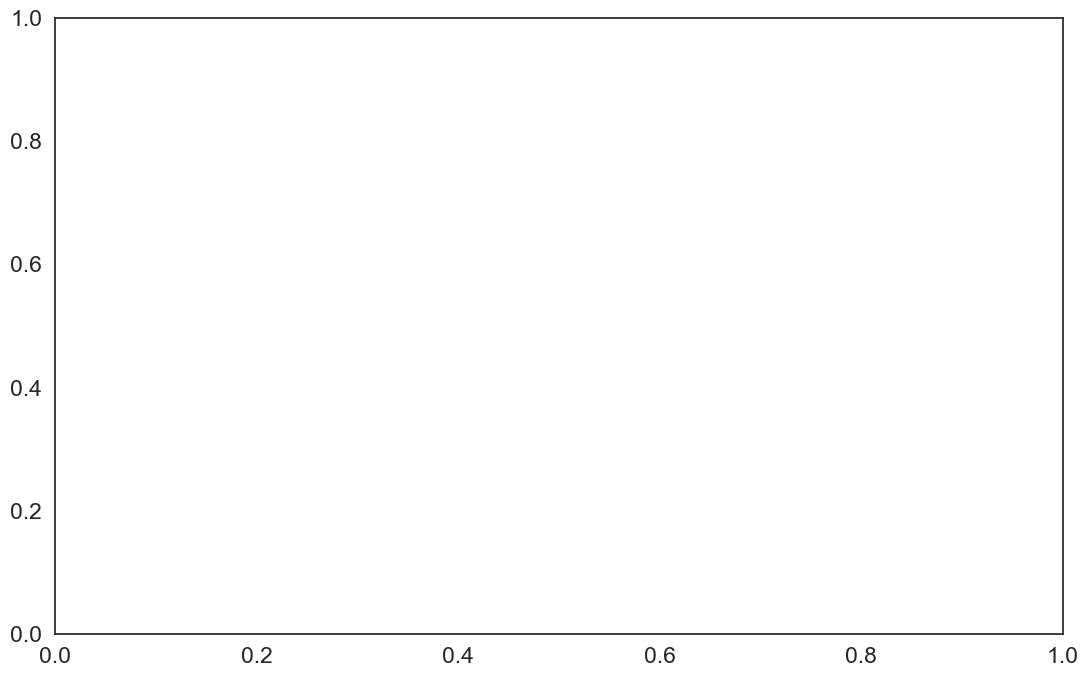

Error in callback <function flush_figures at 0x000001CF7848E340> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [45]:
count = 0
loss_list = []
epoch_list = []
for epoch in range(epochs):
    model_nn.train(True)
    lf_val = 0
    init_er_val = 0
    
    for num in range(train_data.shape[0]):
        # Clear gradients
        optimizer.zero_grad()
        # Forward propagation
        outputs = model_nn(train_data[num])
        # Calculate loss func
        lf = f_equas(model_nn, train_data[num])
        init_er = initial(model_nn, train_data[num])
        loss = lf + init_er
        # Calculating gradients
        loss.backward()
        # Update parameters
        optimizer.step()
    model_nn.train(False)
    z = 0
    for row in val_data:
        lf_val += abs(f_equas(model_nn, row).detach())
        z += 1
        if not z%100 :
            print("lf_val", lf_val, row)
        init_er_val += abs(initial(model_nn, row).detach())
    print(lf_val, init_er_val)
    loss_val= lf_val + init_er_val
    loss_list.append(loss_val[0])
    epoch_list.append(epoch)
    print(f"Loss val {loss_val}, epoch = {epoch}, loss_train {loss}")
    plot_seaborn(epoch_list, loss_list)

In [34]:
x = torch.Tensor([0, 0.2, 0.4, 0.6, 0.8, 1]).reshape(-1, 1)

In [35]:
x[0]

tensor([0.])

In [40]:
for z in x:
    print(model_nn(z))

tensor([1.0047], grad_fn=<ViewBackward0>)
tensor([1.4986], grad_fn=<ViewBackward0>)
tensor([2.2315], grad_fn=<ViewBackward0>)
tensor([3.3261], grad_fn=<ViewBackward0>)
tensor([4.9541], grad_fn=<ViewBackward0>)
tensor([7.3931], grad_fn=<ViewBackward0>)



<code> Xi   Yан(xi)*     Yi(метод Эйл)*   Yi (метод Р-К)*    Yi (метод Р-К-М)*     PINN</code> <div>
<code> 0     1           1               1                 1                     0.9999</code> <div>
<code>0.2    1.49183     1.4             1.49186           1.49184               1.4932</code><div>
<code>0.4    2.22554     2.0151          2.22563           2.22557               2.2247</code><div>
<code>0.6    3.32012     2.9474          3.32028           3.32017               3.3222</code><div>
<code>0.8    4.95303     4.34999         4.95329           4.95313               4.9515</code><div>
<code> 1     7.38906     6.45181         7.38946           7.38921               7.3889 </code><div>

Рунге - Кутта (Р-К) <div>
Рунге - Кутта - Мерсона (Р-К-М)<div>
*Данные взяты из учебного пособия ЧИСЛЕННЫЕ МЕТОДЫ РЕШЕНИЯ КРАЕВЫХ ЗАДАЧ ДЛЯ ОБЫКНОВЕННЫХ <div>
ДИФФЕРЕНЦИАЛЬНЫХ УРАВНЕНИЙ  Крайнов А.Ю.,  Моисеева К.М.